# Flujo de trabajo Bayesiano {#sec-Bayesian-Worflow}

In [1]:
#| code-fold: true

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz

## De datos y suposiciones a insights

Usamos datos para comprender el mundo que nos rodea, lo que podría consistir en revelar el origen del universo, predecir cuándo debemos plantar y cuándo cosechar, o cómo hacer sugerencias de productos útiles para mantener a los clientes interesados y comprando nuestros productos. Sin embargo, el mundo suele ser un lugar complejo y, por lo tanto, los datos deben procesarse e interpretarse para que sean útiles. Una forma de interpretar los datos es construir modelos. Los modelos son útiles porque nos permiten incorporar suposiciones y evaluarlas.

Los modelos funcionan como ficciones científicas; mapas que nos ayudan a navegar relaciones complejas. Por lo general (aunque no siempre), los modelos no son el objeto de interés principal, sino que son andamios que proporcionan un marco estructurado para comprender e interpretar datos.

Al discutir estadística Bayesiana se suele hacer en torno a modelos de probabilidad. Tomamos algunos priors, algunos likelihoods, que luego mezclamos con datos siguiendo como receta el Teorema de Bayes, y Voila!, somos Bayesianos! 

Esta descripción no es incorrecta, simplemente no refleja muchos de los aspectos prácticos de la estadística Bayesiano (o del modelado en general). Lo que sucede es que muchos de esos aspectos prácticos no han sido completamente formalizados (como sí lo ha sido el proceso de inferencia). Incluso para varios de esos aspectos, no tenemos aún buenas herramientas o incluso no tenemos aún buenos marcos conceptuales.

## El flujo de trabajo bayesiano

La siguiente figura muestra un esquema de un flujo de trabajo Bayesiano. Podemos ver que hay muchos pasos. Necesitamos todos estos pasos porque los modelos son sólo elucubraciones de nuestra mente sin garantía de ayudarnos a comprender los datos. Primero debemos ser capaces de construir un modelo y luego comprobar su utilidad y, si no es lo suficientemente útil, seguir trabajando o, a veces, dejar de intentarlo. Es posible que también hayas notado el paso "evaluar muestras". Necesitamos esto porque, normalmente, utilizamos métodos computacionales para resolver modelos Bayesianos, los cuales solos proveen garantías asintóticas. 

![Principales elementos de un flujo de trabajo Bayesiano.](img/Bayesian_workflow.png)

Diseñar un modelo adecuado para una tarea de análisis de datos determinada generalmente requiere una combinación de experiencia estadística, conocimiento del dominio, comprensión de las herramientas computacionales y usualmente mucha perseverancia. Rara vez obtenemos el modelo queremos en un solo paso. Es similar a escribir un programa de computadora. Difícilmente no cometamos errores. Incluso los programas muy cortos requieren algo de prueba y error. Por lo general, es necesario probar, depurar y perfeccionar y, a veces, cambiar de enfoque . Lo mismo ocurre con los modelos estadísticos; después de todo, podemos ver los modelos estadísticos como software generador de datos.

En las siguientes secciones vamos a discutir algunos de los pasos del flujo de trabajo Bayesiano. Y al final vamos a describir un resumen de un trabajo Bayesiano. La mejor forma de lograr familiaridad con el flujo de trabajo Bayesiano y los sub-flujos es resolviendo problemas.

## Pruebas predictivas a priori

La distribución predictiva a priori se define como:


$$
p(y^\ast) =  \int_{\Theta} p(y^\ast \mid \theta) \; p(\theta) \; d\theta
$$

donde $y^\ast$ representa datos no observados pero potencialmente observables, al menos de acuerdo a nuestro modelo. Los datos generados son predictivos ya que son los datos que el modelo esperara ver, es decir son datos no observados pero potencialmente observables. 

Lo que estamos haciendo es marginalizando el likelihood al integrar sobre todos los valores posibles del prior. Por lo tanto, desde la perspectiva de nuestro modelo, estamos describiendo la distribución marginal de los datos, es decir independientemente de los parámetros. En otros palabras estamos generando predicciones del modelo "antes" de ver los datos. Esta distribución representa lo que el modelo "cree" sobre la cantidad modelada.

Obtener esta distribución de forma analítica no siempre es sencillo, pero si lo es computacionalmente, siempre y cuando podamos escribir un modelo en un PPL. Podemos generar muestras de esta distribución según el siguiente procedimiento:

1. Elegimos un valor de $\theta$ de acuerdo a la distribución a priori $p(\theta \mid y)$
2. Fijamos $\theta$ en la distribución que usamos como likelihood $p(y^\ast \mid \theta)$ y generamos una muestra aleatoria
3. Repetimos desde 1, tantas veces como muestras necesitemos

Uno de los usos prácticos de esta distribución es evaluar el modelo. A grandes rasgos esto se puede realizar generando datos a partir de la distribución predictiva a priori y comparándolos con nuestro conocimiento de domino. Es común que las comparaciones sean visuales y semi-cuantitativas, es decir buscamos acuerdos razonables. Por ejemplo podemos hacernos preguntas como ¿La mayor parte de la distribución simulada está en un rango razonable? ¿Existen valores extremos? Es recomendable NO comparar con los datos observados, en cambio usar valores de referencia. Los valores de referencia son datos empíricos u observaciones históricas, normalmente serán valores mínimos, máximos o esperados.

### Predadores y presas

Estamos interesados en modelar la relación entre las masas de organismos que son presas y organismos que son predadores, como las masas varían en órdenes de magnitud desde una célula de 1e-14 gramos a una ballena azul de 1.5e8 gramos, es conveniente trabajar en una escala logarítmica. Entonces un modelo podría ser

\begin{align}
    \mu =& Normal(\cdots, \cdots) \\
    \sigma =& HalfNormal(\cdots) \\
    log(masas) =& Normal(\mu, \sigma)
\end{align}

Para definir los valores del prior, podríamos definir el modelo con algunos priors y ver que implican estos priors en la escala de los datos. Para muestrear de la predictiva a priori usamos `pm.sample_prior_predictive()` en vez de `sample` y necesitamos definir observaciones "dummy". Esto es necesario para indicar cual es el likelihood y para controlar el tamaño de cada distribución predicha.

In [2]:
pp_mass = pd.read_csv("datos/pp_mass.csv")
pp_mass["predator_log"] = np.log(pp_mass["predator"])
pp_mass["prey_log"] = np.log(pp_mass["prey"])

# valores de referencia en escala log
refs = {"Planeta Tierra":np.log(5.97e+27),
        "Ballena Azul":np.log(1.5e8), 
        "Célula más pequeña":np.log(1e-14)}

In [3]:
with pm.Model() as model:
    α = pm.Normal("α", 0, 100)
    β = pm.Normal("β", 0, 100)
    σ = pm.HalfNormal("σ", 5)
    presa = pm.Normal("presa", α + β * pp_mass["prey_log"], σ, observed=pp_mass["predator_log"])
    idata = pm.sample_prior_predictive(samples=100)


Sampling: [presa, α, β, σ]


Podemos ver que el idata no tiene grupo `posterior`, pero si tiene `prior` y `prior_predictive`

In [4]:
idata

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

Nuestro modelo tiene priors tan vagos que todos los valores que ni siquiera podemos distinguir nuestro valores de referencia.

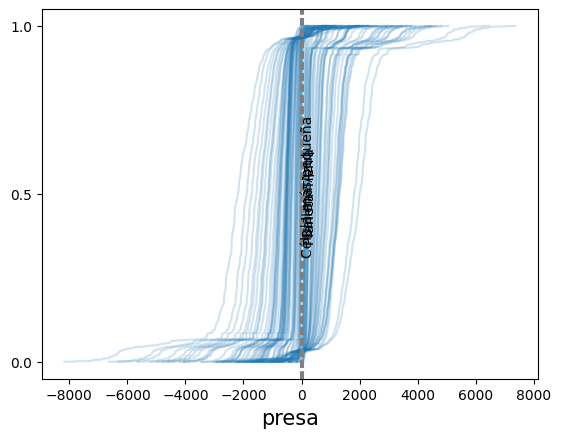

In [5]:
ax = az.plot_ppc(idata, group="prior", kind="cumulative", mean=False, legend=False)

for key, val in refs.items():
    ax.axvline(val, ls="--", color="0.5")
    ax.text(val-7, 0.5-(len(key)/100), key, rotation=90)

In [6]:
with pm.Model() as model:
    α = pm.Normal("α", 0, 1)
    β = pm.Normal("β", 0, 1)
    σ = pm.HalfNormal("σ", 5)
    presa = pm.Normal("presa", α + β * pp_mass["prey_log"], σ, observed=pp_mass["predator_log"])
    idata = pm.sample_prior_predictive(samples=100)

Sampling: [presa, α, β, σ]


Con estos nuevos priors todavía tenemos algunos valores sin sentido, pero al menos la mayor parte de la masa de nuestras predicciones está dentro de rangos razonables.

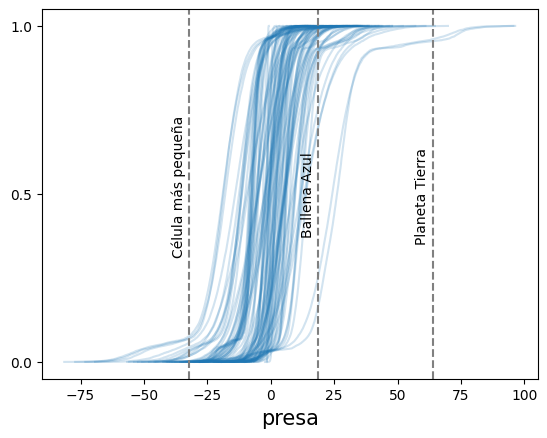

In [7]:
ax = az.plot_ppc(idata, group="prior", kind="cumulative", mean=False, legend=False)

for key, val in refs.items():
    ax.axvline(val, ls="--", color="0.5")
    ax.text(val-7, 0.5-(len(key)/100), key, rotation=90)

PreliZ nos permite hacer algo similar pero de forma interactiva

In [8]:
def pp_model(α_μ=0, α_σ=100, β_μ=0, β_σ=100, σ_σ=5):
    α = pz.Normal(α_μ, α_σ).rvs()
    β = pz.Normal(β_μ, β_σ).rvs()
    σ = pz.HalfNormal(σ_σ).rvs()
    prey = pz.Normal(α + β * pp_mass.predator_log, σ).rvs()
    return prey

refs = {"Earth":np.log(5.97e+27), "Blue whale":np.log(1.5e8), "Smallest cell":np.log(1e-14)}
pz.predictive_explorer(pp_model, references=refs)

## Pruebas predictivas a posteriori

Se define como 

$$
p(\tilde{y}  \mid  y) = \int p(\tilde{y} \mid \theta) p(\theta \mid y) d\theta 
$$

donde $\tilde{y}$ representa los datos generados por un modelo una vez obtenido el _a posteriori_. Es decir, las predicciones del modelo. Es similar a la distribución predictiva a priori, pero esta vez integramos sobre los valores _a posteriori_ de $\theta$

Computacionalmente podemos generar muestras de esta distribución según el siguiente procedimiento:

1. Elegimos un valor de $\theta$ de acuerdo a la distribución a posteriori $p(\theta \mid y)$
2. Fijamos $\theta$ en la distribución que usamos como likelihood $p(\tilde{y} \mid \theta)$ y generamos una muestra aleatoria
3. Repetimos desde 1, tantas veces como muestras necesitemos

Las pruebas predictivas a posteriori son usadas de forma muy extendida para evaluar un modelo. En este caso SI es común compara contra los datos observados. Al comparar con los datos que se usaran para ajustar el modelo este tipo de pruebas son una forma de evaluación de la consistencia interna de un modelo. Es decir, de mínima esperamos que un modelo sea capaz de reproducir los datos usados para ajustarlo.

In [9]:
accidentes = pd.Series([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                       3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                       2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                       1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                       0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                       3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])
años = np.arange(1851, 1962)

In [10]:
with pm.Model() as modelo_cat:
    pc = pm.DiscreteUniform("pc", lower=años.min(), upper=años.max())

    t_0 = pm.Exponential("t_0", 1)
    t_1 = pm.Exponential("t_1", 1)

    tasa = pm.Deterministic("tasa", pm.math.switch(pc >= años, t_0, t_1))

    acc = pm.Poisson("acc", tasa, observed=accidentes)
    idata_cat = pm.sample(1000, random_seed=1791, progressbar=False)
    idata_cat.extend(pm.sample_posterior_predictive(idata_cat, progressbar=False))

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [pc]
>NUTS: [t_0, t_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [acc]


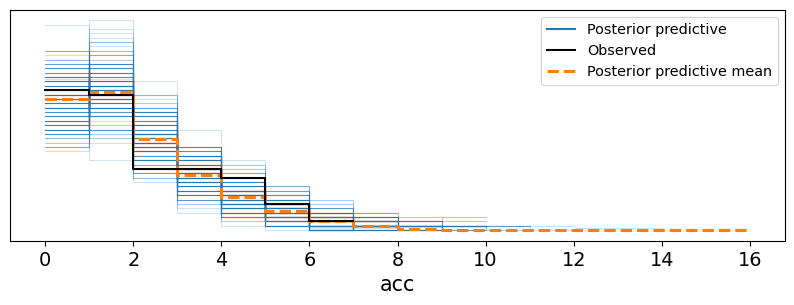

In [11]:
ax = az.plot_ppc(idata_cat, figsize=(10, 3), num_pp_samples=200)
ax.set_xlabel("acc");


## Valores p Bayesianos


Un valor-p Bayesiano se define como:


$$
\text{valor-p Bayesiano} \triangleq p(T_{\text{sim}} \le T_{\text{obs}} \mid \tilde y)
$$

Donde $T$ es un estadístico sumario como la media, mediana, desviación estándar o lo que se desee comparar, que se calcula para los datos observados $T_{\text{obs}}$ y para los datos simulados $T_{\text{sim}}$. 

Si los valores observados coinciden con los predichos, el valor esperado será 0,5. Es decir, la mitad de las predicciones estarán por debajo de las observaciones y la otra mitad por encima.



> Para aquellos que están familiarizados con los valores p y su uso en estadística frecuentista,
hay un par de aclaraciones. Lo que hay de Bayesiano en estos valores p es que
NO estamos utilizando una distribución muestral sino la distribución predictiva posterior.
Además, no estamos haciendo una prueba de hipótesis nula ni tratando de declarar
que una diferencia es “significativa”. 

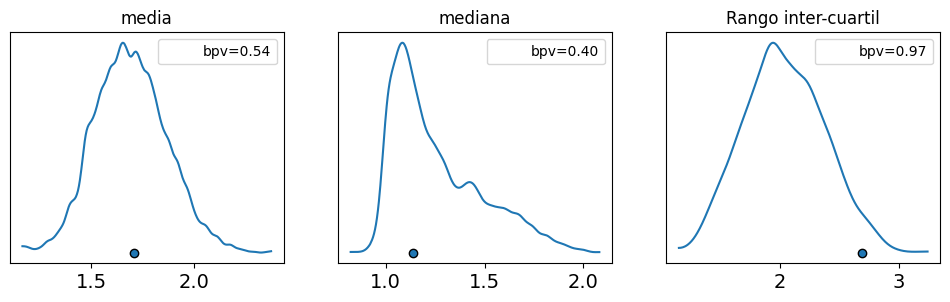

In [12]:
_, ax = plt.subplots(1, 3, figsize=(12, 3))

def iqr(x, a=-1):
    """interquartile range"""
    return np.subtract(*np.percentile(x, [75, 25], axis=a))

az.plot_bpv(idata_cat, kind="t_stat", t_stat="mean", ax=ax[0])
az.plot_bpv(idata_cat, kind="t_stat", t_stat="median", ax=ax[1])
az.plot_bpv(idata_cat, kind="t_stat", t_stat=iqr, ax=ax[2])
ax[0].set_title("media")
ax[1].set_title("mediana")
ax[2].set_title("Rango inter-cuartil");

Un caso especial se da al comparar si los valores simulados son menores que los observados, es decir

$$
p(\tilde y \le y_{\text{obs}} \mid y)
$$

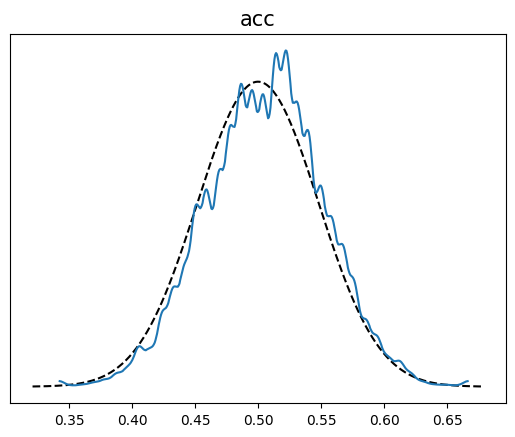

In [13]:
az.plot_bpv(idata_cat, kind="p_value");

Otra posibilidad es realizar la comparación por observación.

$$
p(\tilde y_i \le y_i \mid y)
$$

Esto se suele llamar valor-p marginal y la distribución ideal es uniforme estándar.

La linea blanca en la siguiente figura representa el valor ideal y la banda gris la desviación esperada dado el tamaño de los datos. Los valores de x se pueden interpretar como cuantiles, es decir los valores centrales representan el "seno" de la distribución y los valores extremos las "colas".

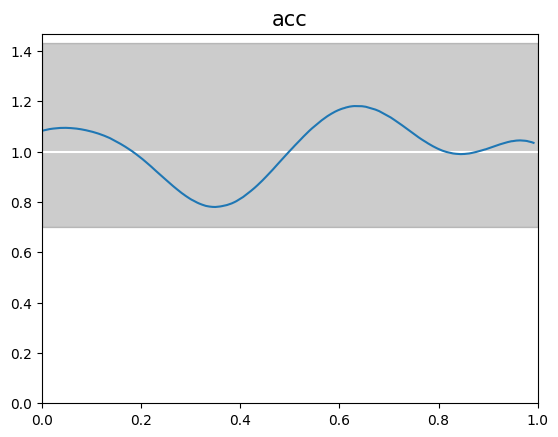

In [14]:
az.plot_bpv(idata_cat);


Por qué esperamos una distribución uniforme? Debido a una propiedad llamada transformada integral de probabilidad (PIT por su sigla en inglés). También llamada a veces universalidad de la uniforme.

Dada una variable aleatoria continua $X$ y CDF $F_X$ podemos computar una variable aleatoria $Y$ con distribución uniforme estándar haciendo.

$$
Y = F_X (X)
$$

Es decir si tomamos una variable aleatoria $X$ y le aplicamos su propia CDF, la transformamos en $Y \sim \mathcal{U}[0, 1]$. Empíricamente podemos ver esto haciendo:

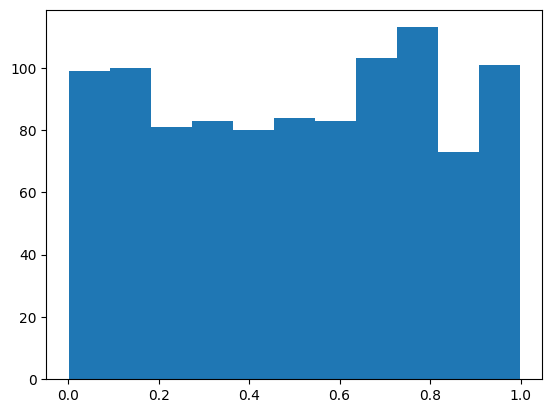

In [15]:
dist = pz.Normal(0, 1)  # Probar con otras distribuciones
plt.hist(dist.cdf(dist.rvs(1000)), bins="auto");

Si desconocemos $F_X$, pero contamos con muestras de $X$, podemos usar la CDF empírica que es lo que estamos haciendo al calcular el valor-p marginal.


In [16]:
dist = pz.Normal(0, 1)  # Probar con otras distribuciones
pred_f = np.exp(dist.rvs(1000))**0.3
obs_f = np.exp(dist.rvs(1000))**0.3

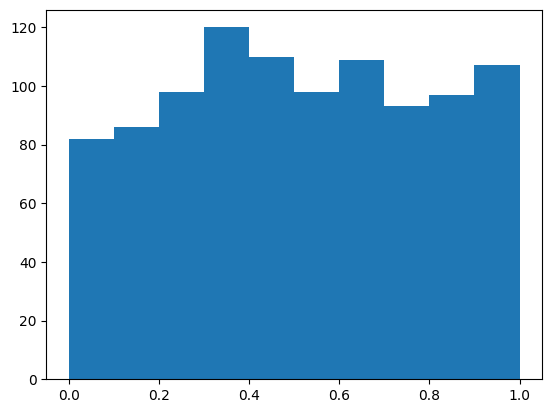

In [17]:
pit = []
for m in obs_f:
    pit.append(np.mean(pred_f <= m))
    
plt.hist(pit);

## Comparación de modelos

### El equilibro entre simplicidad y exactitud

Al elegir entre explicaciones alternativas, existe un principio conocido como la navaja de Occam. En lineas muy generales este principio establece que dadas dos o más explicaciones equivalentes para el mismo fenómeno, la más simple es la explicación preferida. Un criterio común de simplicidad es la cantidad de parámetros de un modelo.

Otro factor que generalmente debemos tener en cuenta al comparar modelos es su exactitud, es decir, qué tan bueno es un modelo ajustando los datos. Según este criterio si tenemos dos (o más) modelos y uno de ellos explica los datos mejor que el otro, entonces ese es el modelo preferido. 

Intuitivamente, parece que al comparar modelos, tendemos a preferir aquellos que mejor ajusten los datos y aquellos que sean más simples. ¿Pero que hacer si estos dos principios se contraponen? O de forma más general, ¿Existe una forma cuantitativa de contemplar ambas contribuciones? La respuesta corta es que si. De hecho hay más de una forma de hacerlo. Pero antes veamos un ejemplo a fin de generar mayor intuición.


### Muchos parámetros (pueden) conducir a sobreajuste

Vamos a comenzar por combinar polinomios cada vez más complejos en un conjunto de datos muy simple. En lugar de utilizar la maquinaria Bayesiana, usaremos la aproximación de mínimos cuadrados para ajustar modelos lineales. 

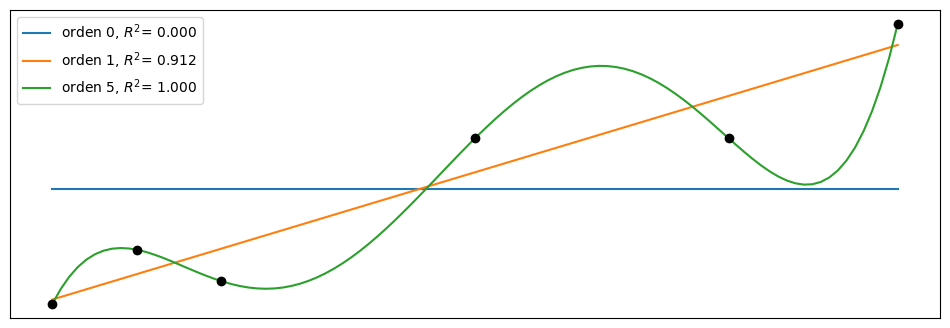

In [18]:
#| code-fold: true

_, ax = plt.subplots(1, 1, figsize=(12, 4))


x0 = np.array([4., 5., 6., 9., 12, 14.])
y0 = np.array([4.2, 6.1, 5., 10., 10, 14.])

order = [0, 1, 5]
ax.plot(x0, y0, 'ko', zorder=3)


ax.set_yticks([])
ax.set_xticks([])

x_n = np.linspace(x0.min(), x0.max(), 100)
ps = []
for i in order:
    p = np.polynomial.Polynomial.fit(x0, y0, deg=i)
    ps.append(p)
    yhat = p(x0)
    ybar = np.mean(y0)
    ss_regression = np.sum((yhat-y0)**2)
    ss_total = np.sum((ybar-y0)**2)
    r2 = 1 - ss_regression / ss_total
    ax.plot(x_n, p(x_n), label=f'orden {i}, $R^2$= {r2:.3f}')

    
ax.legend(loc=2);

De la figura anterior podemos ver que el aumento de la complejidad del modelo se acompaña de una mayor exactitud reflejada en el coeficiente de determinación R². De hecho, podemos ver que el polinomio de orden 5 se ajusta perfectamente a los datos, obteniendo un R²=1. 

¿Por qué el polinomio de grado 5 puede capturar los datos sin perder uno solo de ellos? La razón es que tenemos el mismo número de parámetros que de datos es decir 6. Por lo tanto, el modelo está actuando como una forma alternativa de expresar los datos. El modelo no está *aprendiendo* algo sobre los datos, ¡Está memorizando los datos! A partir de este simple ejemplo, podemos ver que un modelo con mayor ajuste no siempre es lo ideal.


Ahora agregaremos dos datos nuevos y sin volver a ajustar los modelos veremos como cambia el R². Se puede ver que al modelo lineal le va mejor en este caso que al polinomial.

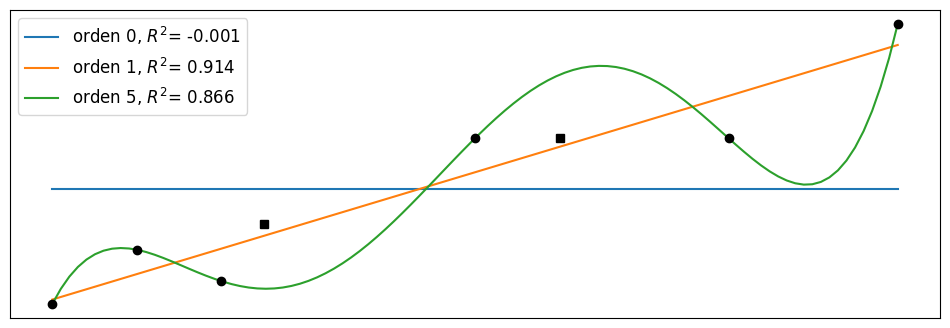

In [19]:
#| code-fold: true

_, ax = plt.subplots( figsize=(12, 4))
x_ = np.array([6.5, 10])
y_ = np.array([7, 10])

ax.plot(x0, y0, 'ko', zorder=3)
ax.plot(x_, y_, 'ks', zorder=3)

ax.set_yticks([])
ax.set_xticks([])

x1 = np.concatenate((x0, x_))
y1 = np.concatenate((y0, y_))

for idx, i in enumerate(order):
    yhat = ps[idx](x1)
    ybar = np.mean(y1)
    ss_regression = np.sum((yhat-y1)**2)
    ss_total = np.sum((ybar-y1)**2)
    r2 = 1 - ss_regression / ss_total
    ax.plot(x_n, ps[idx](x_n), label=f'orden {i}, $R^2$= {r2:.3f}')

    
ax.legend(loc=2, fontsize=12);

Cuando un modelo ajusta muy bien, el conjunto de datos utilizado para aprender los parámetros de ese modelo, pero muy mal otros conjuntos de datos, decimos que tenemos sobreajuste (overfitting). Este es un problema muy común al analizar datos.

Una forma muy útil de pensar el sobreajuste es considerar que un conjunto de datos tiene dos componentes; la señal y el ruido. La señal es lo que queremos capturar (o aprender) de los datos. Si usamos un conjunto de datos es porque creemos que hay una señal allí, de lo contrario será un ejercicio fútil. El ruido, en cambio, no es útil y es el producto de los errores de medición, las limitaciones en la forma en que se generaron o capturaron los datos, la presencia de datos corruptos, etc. Un modelo sobreajusta cuando es tan flexible (para un conjunto de datos) que es capaz de _aprender_ el ruido. Esto tiene como consecuencia que la señal queda oculta.

Esta es una justificación práctica para la navaja de Occam. Y nos advierte que al menos en principio, siempre es posible crear un modelo tan complejo que explique todos los detalles, incluso los más irrelevantes. Tal como en el Imperio descrito por Borges, donde los cartógrafos alcanzaron tal nivel de sofisticación que crearon un mapa del Imperio cuyo tamaño era el del propio Imperio, y que coincidía punto por punto con él.

### Muy pocos parámetros conducen a un subajuste

Continuando con el mismo ejemplo pero en el otro extremo de complejidad, tenemos el modelo de orden 0. Este modelo es simplemente una Gaussiana disfrazada de modelo lineal. Este modelo solo es capaz de capturar el valor de la media de $y$, y es por lo tanto totalente indiferente a los valores de $x$. Decimos que este modelo ha subajustado los datos.

### Medidas de exactitud predictiva


_Todo debe hacerse tan simple como sea posible, pero no más simple_ es una cita que a menudo se atribuye a Einstein. Al igual que en una dieta saludable, al modelar tenemos que mantener un balance. Idealmente, nos gustaría tener un modelo que ni sub-ajuste ni sobre-ajuste los datos. De alguna forma hay que balancear simplicidad y bondad de ajuste.

En el ejemplo previo, es relativamente fácil de ver que el modelo de orden 0 es _demasiado_ simple mientras que el modelo de orden 5 es _demasiado_ complejo. Pero que podemos decir de los otros dos modelos? Cómo podríamos establecer un ranking numérico de estos modelos? Para poder hacer esto necesitamos formalizar nuestra intuición sobre este balance entre simplicidad y exactitud

Veamos un par de términos que nos serán de utilidad.

* **Exactitud dentro de la muestra** (within-sample accuracy). La exactitud medida con los mismos datos usado para ajustar el modelo.
* **Exactitud fuera de la muestra** (out-of-sample accuracy). La exactitud medida con datos no usados para ajustar el modelo.

La exactitud dentro de la muestra será, en promedio, mayor a la exactitud fuera de la muestra. Es por ello que usar la exactitud dentro de la muestra para evaluar un modelo en general conducirá a pensar que tenemos un mejor modelo de lo que realmente es. Utilizar la exactitud fuera de la muestra es por lo tanto una mejor idea para evitar engañarnos a nosotros mismos. Sin embargo, esta aproximación requiere dejar datos fuera del ajuste, lo cual es un lujo que en general no nos podemos dar. Ya que este es un problema central en el análisis de datos existen varias propuestas para abordarlo. Dos aproximaciones muy populares son:


* Validación cruzada: esta es una estrategia empírica basada en dividir los datos disponibles en subconjuntos separados que se utilizan para ajustar y evaluar de forma alternativa

* Criterios de información: este es un término general usado para referirse a varias expresiones que  aproximan la exactitud fuera de la muestra como la exactitud dentro de la muestra más un término que penaliza la complejidad del modelo.

### Validación cruzada

La validación cruzada es una solución simple y, en la mayoría de los casos, efectiva para comparar modelos. Tomamos nuestros datos y los dividimos en K porciones. Intentamos mantener las porciones más o menos iguales (en tamaño y, a veces, también en otras características, como, por ejemplo, un número igual de clases). Luego usamos K-1 porciones para entrenar el modelo y el resto para evaluarlo. Este proceso se repite sistemáticamente dejando, por cada iteración, una porción diferente fuera del conjunto de entrenamiento y usando esa porción como el conjunto de evaluación. Esto se repite hasta que hayamos completado K rondas de ajuste-evaluación. La exactitud del modelo será la del promedio a lo largo de las K rondas. Esto se conoce como validación cruzada K-fold. Por último, una vez que hemos realizado la validación cruzada, usamos todos los datos para ajustar por última vez nuestro modelo y este es el modelo que se utiliza para hacer predicciones o para cualquier otro fin.

<img src='img/cv.png' width=500 >

Cuando K es igual a la cantidad de puntos de datos, obtenemos lo que se conoce como _validación cruzada dejando uno afuera_ (LOOCV del inglés leave-one-out cross-validation). 

La validación cruzada es una práctica de rutina en _machine learning_. Y apenas hemos descripto los aspectos más esenciales de esta práctica. Para mayor información pueden leer [The Hundred-Page Machine Learning Book](http://themlbook.com/)  o [Python Machine Learning](https://www.amazon.com/Python-Machine-Learning-scikit-learn-TensorFlow-ebook/dp/B0742K7HYF/ref=dp_ob_title_def), by Sebastian Raschka, o [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) by Jake Vanderplas.

La validación cruzada es una idea muy simple y útil, pero para algunos modelos o para grandes cantidades de datos, el costo computacional de la validación cruzada puede estar más allá de nuestras posibilidades. Muchas personas han tratado de encontrar cantidades más simples de calcular que se aproximen a los resultados obtenidos con la validación cruzada o que funcionen en escenarios donde la validación cruzada no puede ser tan fácil de realizar. Y ese es el tema de la siguiente sección.

### Criterios de información


Los criterios de información son una colección de herramientas estrechamente relacionadas que se utilizan para comparar modelos en términos de la bondad del ajuste y de la complejidad del modelo. En otras palabras, los criterios de información formalizan la intuición que desarrollamos al comienzo del capítulo. 
La forma exacta en que se derivan estas cantidades tiene que ver con un campo conocido como [Teoría de la Información](http://www.inference.org.uk/mackay/itila/book.html).


Una forma intuitiva de medir qué tan bien un modelo se ajusta a los datos es calcular el error cuadrático medio entre los datos y las predicciones realizadas por el modelo:


$$
\frac{1}{N} \sum_i^N  (y_i - \operatorname{E} (y_i \mid \theta))^2
$$


$\operatorname{E} (y_i \mid \theta)$ es el valor predicho dados los parámetros estimados. Es importante notar que esto es esencialmente el promedio de la diferencia entre los datos observados y los predichos.
Tomar el cuadrado de los errores asegura que las diferencias no se cancelen y enfatiza grandes errores comparado con otros alternativas como por ejemplo calcular el valor absoluto.

El error cuadrático medio, puede resultarnos familiar ya que es muy popular. Pero si nos detenemos a reflexionar sobre esta cantidad veremos que en principio no tiene nada de especial y bien podríamos idear otras expresiones similares. Intentemos encontrar una métrica más general y compatible con la aproximación probabilista de este curso.

### Entropia

For a probability distribution with $N$ possible different events which each possible event having probability $p_i$, the entropy is defined as:

$$
H(p) = - \mathbb{E}[\log{p}] = -\sum_i^N p_i \log{p_i}
$$

La entropía es una medida de la incertidumbre de una distribución. En este sentido podemos decir que la incertidumbre contenida en una distribución es el logaritmo de la probabilidad promedio de un evento. Si solo un evento es posible la entropía será 0, si todos los eventos tienen la misma probabilidad la entropía será máxima. El concepto de entropía se puede extender a distribuciones continuas, pero no vamos a entrar en esos detalles.

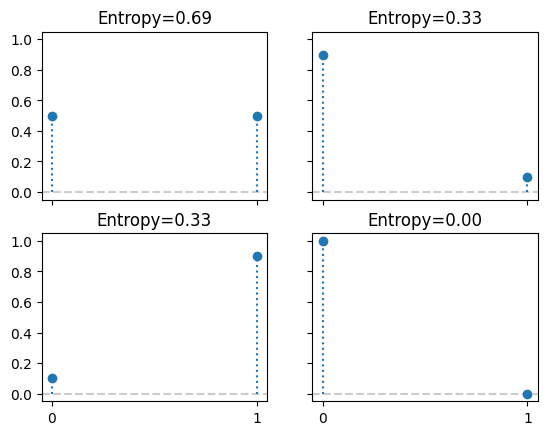

In [72]:
_, axes = plt.subplots(2, 2, sharex=True, sharey=True)

for p, ax in zip([0.5, 0.1, 0.9, 0.0001], axes.ravel()):
    dist = pz.Bernoulli(p=p)
    dist.plot_pdf(ax=ax, legend=False)
    ax.set_title(f"Entropy={dist.entropy():.2f}")
    ax.set_ylim(-0.05, 1.05)

El concepto de entropía aparece muchas veces en estadística. Puede ser útil, por ejemplo al definir priors. En general queremos utilizar un prior que sea de máxima entropía dado nuestro conocimiento (ver por ej funcion `maxent` de PreliZ). Y también a la hora de comparar modelos. Veamos.


Supongamos que tenemos una distribución objetivo $p$, con la cual no podemos trabajar de forma directa y solo tenemos acceso a $q$. Queremos evaluar que tan bien $q$ approxima a $p$, o si $q$ es una familia paramétrica encontrar que parámetros hacen que $q$ sea lo más cercana a $p$ que sea posible. Una forma de hacer esto es medir la divergencia de Kulback-Leibler:

$$
\mathbb{KL}(p \parallel q) =  \overbrace{-\sum_i^N p_i \log{q_i}}^{H(p, q)} -  \overbrace{\left(-\sum_{i}^n p_i \log{p_i}\right)}^{H(p)}
$$

Fijense que tiene dos componentes la entropia de $p$, $H(p)$ y la entropía cruzada $H(p, q)$, es decir la entropía de $q$ pero evaluada según $p$.  Esto puede parecer algo abstracto, pero si pensamos que tenemos $N$ muestras que asumimos provienen de una distribución $p$ desconocida y tenemos un modelo descripto por $q(y \mid \theta)$, entonces veremos que estamos describiendo una situación típica en análisis de datos.

Según esta expresión la divergencia de KL representa la entropía "extra" que introducimos al aproximar $p$ por $q$. Es común encontrarla escrita de otras formas, como:

$$
\mathbb{KL}(p \parallel q) \quad=\quad- \sum_i^N p_i (\log{q_i} - \log{p_i}) \quad=\quad \mathbb{E}_p[\log{p}] - \mathbb{E}_p[\log{q}] \quad=\quad \sum_i^N p_i \log{\frac{p_i}{q_i}}
$$


Todas formas equivalentes y útiles depediendo en contexto. Algo común en todas estas expresiones es que no podemos aplicar de forma directa si $p$ es desconocida. Por ejemplo si $p$ representa el **proceso generador de datos** o la **población** o la distribución **verdadera**, estamos perdidos... Pero, si lo que nos interesa es comparar modelos veremos que NO es necesario el cálculo directo, la razón es que aún cuando desconozcamos $p$ su entropía es un término constante.

$$
\begin{split}
        \mathbb{KL}(p \parallel q_0) =&\; \mathbb{E}[\log{p}] - \mathbb{E}[\log{q(y \mid \theta_0)}] \\
        \mathbb{KL}(p \parallel q_1) =&\; \mathbb{E}[\log{p}] - \mathbb{E}[\log{q(y \mid \theta_1)}] \\
        &\cdots \\
        \mathbb{KL}(p \parallel q_2) =&\; \mathbb{E}[\log{p}] - \mathbb{E}[\log{q(y \mid \theta_2)}]
\end{split}
$$

Si comparamos modelos entonces el mejor modelo, dado el conjunto de modelos comparados, será aquel que tenga un valor más grande de verosimilitud. En otras palabras mimimizar la divergencia de KL es proporcional a maximizar la verosimilitud (likelihood). 

En la práctica tampoco tenemos acceso a $\mathbb{E}[\log{q}]$, lo que podemos hacer es estimar esta cantidad a partir de una muestra, pero como ya sabemos usar una muestra para estimar los parámetros de un modelo y usar la misma muestra para evaluarlo introduce un sesgo, que de alguna manera debemos corregir. Una forma de corregir este sesgo viene dada por los criterior de información.

#### Criterio de información de Akaike 

Este es un criterio de información muy conocido y ampliamente utilizado fuera del universo Bayesiano y se define como:

$$
AIC = -2 \sum_i^N \log p(y_i \mid \hat{\theta}_{mle}) + 2 k
$$

Donde, $k$ es el número de parámetros del modelo y $\hat{\theta}_{mle}$ es la estimación por máxima verosimilitud para $\theta$. Para el resto de nuestra discusión vamos a omitir la constante -2 y escribir 


$$
AIC = \sum_i^N \log p(y_i \mid \hat{\theta}_{mle}) - k
$$

De esta forma es más fácil ver que el criterio de Akaike es una maxima-verosimilitud penalizada (se hace más chica, se minimiza) mientras más parámetros tenga un modelo.Además, esta versión sin el -2 tiene una correspondencia más clara con otras expresiones que veremos a continuación.

Qué el número de parámetros sea un criterio válido de penalización es intuitivo, ya que como vimos en el ejemplo anterior con los polinomios, un modelo con mayor número de parámetros es, en general, más flexible. Pero es importante destacar que el criterio de Akaike tiene una justificación teórica, no es que Akaike simplemente pensó que usar $k$ era buena idea.


El criterio de AIC es muy útil, pero presenta problemas para modelos Bayesianos. Una de las razones es que no utiliza la distribución a posteriori de $\theta$ y, por lo tanto, descarta información. Además AIC, desde una perspectiva Bayesiana, asume que los priors son *planos* y, por lo tanto, AIC es incompatible con priors informativos y/o ligeramente informativos. Además, la cantidad de parámetros de un modelo no es una buena medida de la complejidad del mismo cuando se usan priors informativos o estructuras como la jerárquica. Agregar información a un modelo en su estructura, equivale a reducir la _cantidad efectiva de parámetros_, algo también conocido como *regularización*.

Podemos encontrar una expresión equivalente, pero mejor ajustada a modelos Bayesianos?

### WAIC

Como ya vimos en el criterio de Akaike, la bondad del ajuste viene dada por:

$$
\sum_i^N \log p(y_i \mid \hat{\theta}_{mle})
$$

Pero en estadística Bayesiana, NO tenemos una estimación puntual de $\theta$. Tenemos una distribución, por lo que deberíamos hacer:

$$
\sum_i^N \log
    \int \ p(y_i \mid \theta) \; p(\theta \mid y) d\theta
$$

Como en general no tenemos una expresión analítica para el posterior, $p(\theta \mid y)$, pero tenemos unas serie de muestras (como las obtenidas por MCMC), entonces podemos aproximar la integral por:

$$
\sum_i^N \log \left(\frac{1}{S} \sum_{j}^S p(y_i \mid \theta^j) \right)
$$

LLamaremos a esta cantidad ELPD, que es la sigla en inglés para valor esperado de la densidad log-predictiva. 

OK, ya tenemos como medir la bondad de ajuste. Ahora necesitamos un término que penalice la complejidad del modelo. Encontrar la expresión correcta para esto, requiere de trabajo, asi que la vamos a presentar sin justificar. Este nuevo criterio (la versión Bayesiana de Akaike) se llama Widely applicable information criterion:

$$
WAIC = \sum_i^N \log \left(\frac{1}{S} \sum_{j}^S p(y_i \mid \theta^j) \right) - \sum_i^N  \left( V_{j}^S \log p(y_i \mid \theta^j) \right)
$$


Donde el término de penalización viene dado por la varianza de los log-likelihoods sobre las $S$ muestras del posterior. Intuitivamente el término penaliza modelos que tengan mucha variabilidad en sus predicciones. Veamos como ejemplo un modelo lineal:

$$
Y = \alpha + \beta X
$$

Un modelo donde $\beta=0$ será menos flexible, ya que equivale a un modelo que solo tiene un parámetro, $\alpha$. De forma un poco más sutil un modelo donde $\beta$ varía en un rango estrecho será menos flexible (más regularizado), que un modelo donde $\beta$ puede tomar cualquier valor.

### LOO y la validación cruzada (aproximada)


Existe otra alternativa para penalizar el término

$$
\sum_i^N \log \left(\frac{1}{S} \sum_{s=1}^S p(y_i \mid \theta^s) \right)
$$

Y es calcular

$$
\sum_i^N \log
    \left( \frac{1}{S}\sum_j^S \mathbin{\color{#E9692C}{p(y_i \mid \theta_{-i}^j)}} \right)
$$


donde $_{-i}$ quiere decir que dejamos la observación $i$ afuera. Una implementación Naive de esta estimación requiere que estimemos tantas distribuciones a posteriori como datos tengamos, ya que para cada una de ellas eliminaremos una observación. Sin embargo, esto no es necesario ya que es posible estiamar $\color{#E9692C}{p(y_i \mid \theta_{-i}^j})$ usando **Muestreo de Importancia** (importance sampling).

Antes de seguir con nuestra agenda, necesitamos hacer un pequeño detour.

#### Muestreo de importancia

Esta es una técnica para estimar propiedades de una distribución de interés $f$, dado que solo tenemos muestras de una distribución $g$. Usar el muestreo de importancia tiene sentido, por ejemplo, cuando es más simple muestrear $g$ y no $f$. 

Si tenemos un conjunto de muestras de la variable aleatoria $X$ y podemos evaluar $g$ y $f$ puntualmente, podemos calcular los pesos de importancia como:

\begin{equation}
     w_i = \frac{f(x_i)}{g(x_i)}
\end{equation}

Computacionalmente queda de la siguiente manera:

* Extraer $N$ muestras $x_i$ de $g$
* Calcular la probabilidad de cada muestra $g(x_i)$
* Evaluar $f$ sobre las $N$ muestras $f(x_i)$
* Calcular los pesos de importancia $w_i = \frac{f(x_i)}{g(x_i)}$



Una vez obtenidos los pesos $w_i$, podemos usarlos para estimar propiedades de $f$, su densidad, momentos, cuantiles, etc.

A continuación se muestre un bloque de código donde $g$ es una Normal y $f$ una Gamma y usamos muestreo de importancia para estimar la PDF de $f$. Este es solo un ejemplo didáctico, ya que en realidad sabemos como calcular la PDF de una Gamma. Pero en la práctica $f$ puede ser un objeto mucho más complejo.  

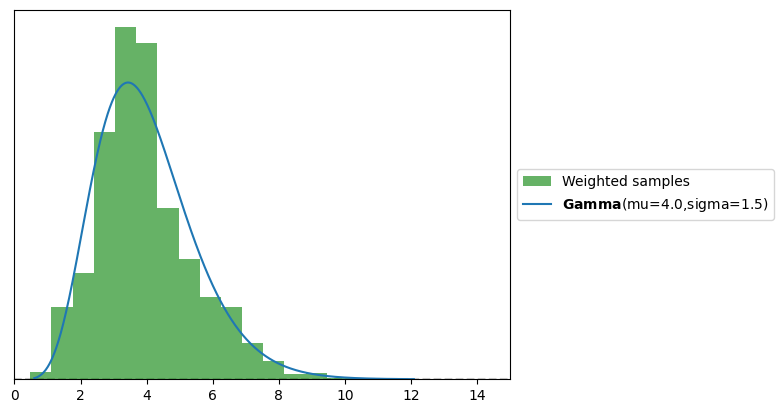

In [20]:
g = pz.Normal(0, 10)
samples = g.rvs(1000)
f = pz.Gamma(mu=4, sigma=1.5)

w = f.pdf(samples) / g.pdf(samples)

plt.hist(samples, bins=100, density=True, weights=w, alpha=0.6, color='C1', label='Weighted samples')
plt.xlim(0, 15)


f.plot_pdf();

Al hacer muestreo de importancia mientras más similares sean $g$ y $f$ mejor serán los resultados. En la práctica las inferencias son más confiables cuando $g$ tiene un soporte mayor que $f$, es decir cuando es más "ancha", intuitivamente necesitamos que las muestras de $g$ cubran todo el soporte de $f$ (o al menos las regiones de densidad alta).

### Retomando

Ahora que tenemos una mejor idea de muestreo por importancia veamos como podemos usarlo. La distribución que conocemos es la distribución a posteriori, y la que queremos aproximar por muestreo de importancia es la distribución a posteriori dejando uno afuera $p(y_i \mid \theta_{-i}^j)$. Por lo que los pesos de importancia que nos interesa calcular son:

$$
w_i^j = \frac{p(\theta^j \mid y_{-i} )}{p(\theta^j \mid y)} \propto \frac{p(\theta) \prod_{i\not=-i}^n p(y_i \mid \theta)}{p(\theta) \prod_i^n p(y_i \mid \theta)} \propto \frac{1}{p(y_i \mid \theta^j)} 
$$

Es decir los términos comunes (y que por lo tanto se cancelan) entre numerador y denominador son todos menos el likelihood para la observación que queremos remover. Nótese que los pesos son proporcionales y no están normalizados, pero esto no es un problema ya que se pueden normalizar simplemente dividiendo cada peso por la suma total de los pesos. 


Este resultado es una gran noticia, porque nos dice que es posible calcular el ELPD por validación cruzada dejando uno afuera, a partir de un solo ajuste de los datos! y que solo necesitamos los valores de los log-likelihoods, cuyo costo computacional es, en general, muy bajo. 

La trampa, por que siempre hay una trampa, es que es esperable que $p(\theta^j \mid y_{-i} )$ sea más "ancha" que $p(\theta^j \mid y)$, ya que es una distribución a posteriori estimada con una observación menos. Esto es lo contrario al caso ideal en muestreo por importancia. Para muchos casos puede que la diferencia no sea relevante, ya que eliminar una observación puede conducir a una distribución a posteriori prácticamente equivalente. Pero en algunos casos la diferencia puede ser relativamente grande. Cuándo? Pues, mientras más "influyente" sea la observación. En términos de importance sampling esto se traduce en pesos con mayor importancia relativa y que por lo tanto tienen a dominar la estimación. 

Una forma de corregir esto problema es simplemente truncando los pesos "demasiado altos", pero esto trae otros problemas que no vamos a discutir. Otra forma consiste en respaldarse en la teoría. La teoría indica que bajo ciertas condiciones los pesos altos se distribuyen según una Pareto. Por lo que en vez de truncarlos podemos ajustarlos a una distribución de Pareto y luego remplazarlos por valores obtenidos de esa distribución. Esto es una forma de suavizado que, dentro de cierto rango, permite estabilizar la estimación por muestreo de importancia, ya que hará que alguno valores "muy grandes" no lo sean tanto. 

Cuando combinamos todas estas ideas obtenemos un método llamado Pareto-Smooth Importance Sampling Leave-One-Out Cross Validation, que se abrevia como PSIS-LOO-CV. Dado que el nombre y la sigla son horriblemente largo y difíciles de pronunciar nosotros lo llamaremos LOO (pronunciado como "lu").



### LOO y WAIC

Asintóticamente LOO y WAIC convergen, y además funcionan bajo el mismo conjunto de supuestos. Por lo que teóricamente son equivalentes. Sin embargo en la práctica LOO es más robusto, y además nos ofrece un diagnóstico que indica cuándo podría estar fallando (esto gracias al ajuste de Pareto). Por lo que en la práctica preferimos LOO.

### Calculando LOO

Luego de toda esta introducción calcular LOO, puede parecer algo decepcionante. Solo tenemos que llamar a la función `loo` de ArviZ y pasarle un objeto InfereceData que contenga el grupo log-likelihood. Por defecto PyMC NO agrega este grupo al llamar a `pm.sample`. Podemos calcularlo junto con el posterior si hacemos `pm.sample(., )`

In [21]:
with modelo_cat:
    pm.compute_log_likelihood(idata_cat,
                              extend_inferencedata=True,  # actualizamos "in-place"
                              progressbar=False,
                             )  

In [22]:
loo_p = az.loo(idata_cat)
loo_p

/home/osvaldo/proyectos/00_BM/arviz-devs/arviz/arviz/stats/stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 111 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -171.18     7.90
p_loo        2.92        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.7]   (good)      108   97.3%
   (0.7, 1]   (bad)         1    0.9%
   (1, Inf)   (very bad)    2    1.8%

Podemos ver que obtenemos el valor del ELPD estimado usando LOO y su error estándar. `p_loo` se puede interpretar aproximadamente como el número efectivo de parámetros. De hecho, si cuentan el número de parámetros de `modelo_cat` verán que es efectivamente 3. 

Luego podemos ver una tabla con los "Valor del diagnóstico de Pareto k". Ya algo adelantamos sobre esto. Dijimos que usábamos una Pareto para regularizar la estimación de los pesos de importancia. Uno de los parámetros de ese ajuste se llama k. Como tenemos un ajuste de Pareto por observación tenemos un valor k por observación. Este parámetro es útil por que nos indica dos caras de una misma moneda, nos dice cuando una observación es "muy influyente" y nos indica que la aproximación empleada por LOO podría estar fallando para esa observación (lean el mensaje de advertencia con fondo rosa).

Como regla general si k es menor a 0.7 no hay problemas, si estamos entre 0.7 y 1 es muy probable que estemos en problemas y si el mayor a 1, estamos perdidos. El valor corte 0.7 no es fijo, estrictamente puede ser menor y depende del número total de muestras de la distribución a posteriori, 4000, en este ejemplo. Pero cuando el número es un poco mayor a 2000 ya estamos casi en 0.7. En la práctica es común usar valores de muestras de 2000 o mayores. Incrementar el número de muestras (`draws` en la función `pm.sample`) puede reducir el valor de k y por lo podríamos remover algunas de estas advertencias, pero en general el número necesario podría ser demasiado grande como para que tenga sentido práctico.

Es posible visualizar los valores de k, usando `plot_khat`

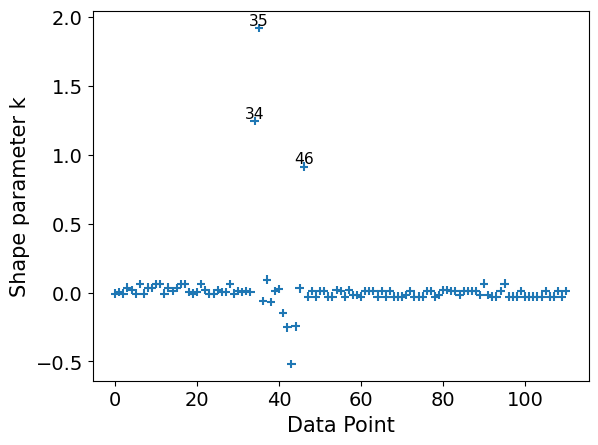

In [23]:
az.plot_khat(loo_p, threshold=0.7);

Si bien la función principal de LOO es comparar modelos, los valores de k puede ser útiles incluso si solo tenemos uno. Por ejemplo podríamos tener conocimiento extra que nos indique por qué estas observaciones son influyentes, quizá hubo un problema en la toma de datos y los valores son incorrectos. O quizá los valores son correctos pero desde la perspectiva de nuestro modelo son influyentes, "extraños", "sorprendentes".

 Si k > 0.7, el valor de p_loo puede darnos algo más de información. Siendo $p$ es el número total de parámetros en un modelo.

* Si p_loo << p entonces el modelo debe estar mal-especificado. Esto debería verse también en las pruebas predictivas a posteriori. Una solución es usar un modelo sobredispersado (como cambiar una Poisson por una NegativaBinomial o por una ZeroInflatedPoisson o HurdlePoisson, o cambiar una Normal por una T de Student, etc). O es probable que el modelo necesite más estructura o complejidad, quizá necesitamos un término no-lineal, etc

* Si p_loo < p y las observaciones son relativamente pocas comparadas con $p$, (digamos p>N/5). Es probable que tengamos un modelo demasiado flexible y/o priors demasiado vagos. Esto puede pasar para modelos jerárquicos con muy pocas observaciones por grupo o por ejemplo para splines con muchos nudos o Procesos Gaussianos con valores de escala muy cortos

* If p_loo > p, entonces el modelo tiene problemas muy serios. Si p<<N, entonces las pruebas predictivas a posterior también deberían reportar problemas. Si en cambio p es relativamente grande (digamos p>N/5). Entonces es posible que las pruebas predictivas a posteriori no reflejen problemas.


Por último, otra forma de usar LOO incluso en ausencia de otro modelo es mediante `plot_loo_pit`. Si el gráfico luce similar al que vimos para los valores p-Bayesianos marginales, es por que estamos haciendo lo mismo. Pero esta vez al usar LOO, estamos considerando:



$$
p(\tilde y_i \le y_i \mid y_{-i})
$$

Es decir estamos evaluando, de forma aproximada, la capacidad del modelo de predecir una observación cuando removemos esa observación de los datos observados. 

<Axes: xlabel='acc'>

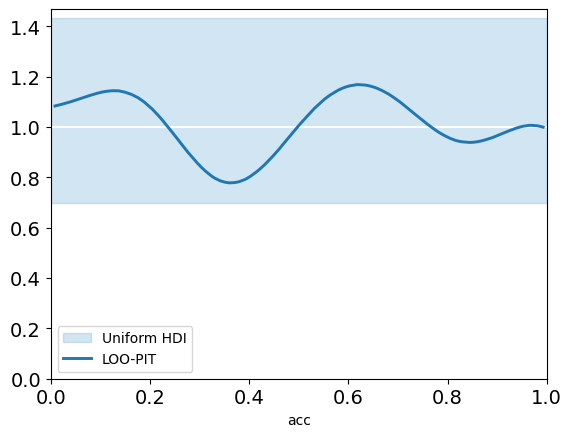

In [24]:
az.plot_loo_pit(idata_cat, y="acc", use_hdi=True)

#### Otros criterios de información

Otro criterio de información muy usado es DIC, si usamos el *bayesómetro™*, DIC es más bayesiano que AIC pero menos que WAIC. Aunque aún es popular, WAIC y principalmentete LOO han demostrado ser más útiles tanto teóricamente como empíricamente que DIC. Por lo cual NO recomendamos su uso.

Otro criterio muy usado es BIC (del inglés Bayesian Information Criteria), al igual que la regresión logística y la *sopa seca* de mi madre, este nombre puede ser engañoso. BIC se propuso como una forma de corregir algunos de los problemas con AIC y el autor propuso una justificación Bayesiana para ello. Pero BIC no es realmente Bayesiano en el sentido que al igual que AIC asume priors *planos* y utiliza una estimación por máxima verosimilitud.

Pero lo que es más importante, es que BIC difiere de AIC y WAIC en su objetivo. AIC y WAIC intentan reflejar cuál modelo generaliza mejor a otros datos (exactitud predictiva) mientras que BIC intenta identificar cuál es el modelo _correcto_ y por lo tanto está más relacionado a los factores de Bayes que con WAIC. Más adelante discutiremos Factores de Bayes y veremos cómo se diferencia de criterios como WAIC y LOO.

In [26]:
target = pz.StudentT(nu=4, mu=0, sigma=1).rvs(200)

with pm.Model() as modelo_n:
    μ = pm.Normal("μ", 0, 1)
    σ = pm.HalfNormal("σ", 1)
    pm.Normal("y", μ, σ, observed=target)
    idata_n = pm.sample(idata_kwargs={"log_likelihood":True})
    
with pm.Model() as modelo_t:
    μ = pm.Normal("μ", 0, 1)
    σ = pm.HalfNormal("σ", 1)
    ν = pm.Exponential("ν", scale=30)
    pm.StudentT("y", nu=ν, mu=μ, sigma=σ, observed=target)
    idata_t = pm.sample(idata_kwargs={"log_likelihood":True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Output()

In [27]:
cmp_df = az.compare({'modelo_n':idata_n, 'modelo_t':idata_t})
cmp_df

/home/osvaldo/proyectos/00_BM/arviz-devs/arviz/arviz/stats/stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
modelo_t,0,-385.178047,3.073423,0.000000,1.0,17.274565,0.00000,False,log
modelo_n,1,-448.317291,10.794644,63.139244,0.0,37.293694,27.61818,True,log


En las filas tenemos los modelos comparados y en la columnas tenemos

* rank : el orden de los modelos (de mejor a peor)
* elpd : la estimación puntual del elpd usando
* p : los parámetros efectivos
* elpd_diff : la diferencia entre el ELPD del mejor modelo y los demás modelos
* weight : el peso relativo de cada modelo. Si quisieramos hacer predicciones combinando los distintos modelos, en vez de elegir uno solo, este sería el peso que deberíamos asignar a cada modelo. En este caso vemos que `model_t` se lleva todo el peso.
* se : el error estándard del ELPD
* dse : el error estándard de las diferencias
* warning : una advertencia sobre si hay almenos un valor k alto
* scale : la escala en la que se calcula el ELPD

También podemos obtener más o menos la misma información de forma gráfica usando la función `az.compareplot

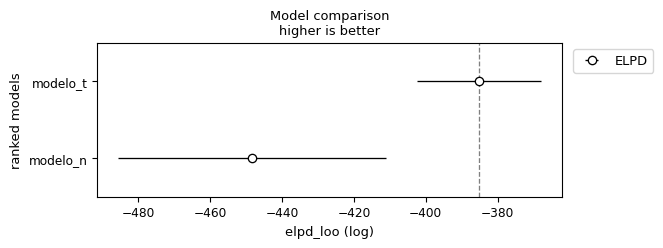

In [28]:
az.plot_compare(cmp_df, plot_ic_diff=False);

* Los círculos vacíos representan los valores del ELPD y líneas negras el error estándar.
* El valor más alto del ELPD se indica con una línea gris discontinua vertical para facilitar la comparación con otros valores.
* Para todos los modelos, excepto *el mejor*, también obtenemos un triángulo que indica el valor de la diferencia del ELPD entre cada modelo y el *mejor* modelo. La barra de error gris que indica el error estándar de las diferencias entre las estimaciones puntuales.

La forma más sencilla de utilizar los criterios de información es elegir un único modelo. Simplemente elija el modelo con el valor más alto de ELPD. Si seguimos esta regla tendremos que aceptar que el modelo cuadrático es el mejor. Incluso si tenemos en cuenta los errores estándar podemos ver que estos no se solapan. Lo que nos da cierta seguridad que efectivamente los modelos son *diferentes* entre si. Si, en cambio, los errores estándar se superpusieran, deberíamos proporcionar una respuesta más matizada.

## Métodos numéricos de Inferencia Bayesiana 

La estadística Bayesiana es una técnica flexible y poderosa que ofrece un marco conceptual unificado para el análisis de datos. Lamentablemente esta formulación conduce a expresiones que no siempre tienen solución analítica por lo que se requiere de métodos numéricos de inferencia. Los lenguajes de programación probabilista (lpp) han sido propuestos como una forma de superar estas limitaciones técnicas y facilitar la creación de modelos probabilistas. El objetivo de los lpp es unificar los lenguajes de programación general con el modelado probabilista, permitiendo que estudiantes, investigadores y practicantes se focalicen en crear e interpretar modelos en vez de tener que lidiar con *detalles* computacionales y/o matemáticos. La posibilidad de aplicar métodos Bayesianos a una amplia variedad de problemas sin requerir, por parte del analista, de avanzados conocimientos matemáticos y computacionales es relativamente reciente. Este hito descansa, principalmente, en el aumento de poder de cálculo y en el desarrollo de métodos de inferencia automática. Para entender donde radica la dificultad de la inferencia Bayesiana podemos revisitar el teorema de Bayes.

$$
\underbrace{p(\boldsymbol{\theta} \mid \boldsymbol{Y})}_{\text{posterior}} = \frac{\overbrace{p(\boldsymbol{Y} \mid \boldsymbol{\theta})}^{\text{likelihood}}\; \overbrace{p(\boldsymbol{\theta})}^{\text{prior}}}{\underbrace{{p(\boldsymbol{Y})}}_{\text{marginal likelihood}}}
$$

El teorema de Bayes, tiene una formulación que a primera vista parece muy inocente. Pero el diablo está en los detalles. El likelihood marginal toma la forma de una integral.

$$
{p(\boldsymbol{Y}) = \int_{\boldsymbol{\Theta}} p(\boldsymbol{Y} \mid \boldsymbol{\theta})p(\boldsymbol{\theta}) d\boldsymbol{\theta}}
$$

Esta integral suele ser difícil de resolver. Veamos, esta expresión nos dice que debemos evaluar el likelihood para cada uno de los posibles valores del prior $\theta$. En la práctica esa tarea no siempre es sencilla o barata de realizar. Si $\theta$ representa un solo parámetro desconocido (como en el modelo beta-binomial) entonces solo hay que resolver una integral 1D, pero si $\theta$ representa dos parámetros (como en el modelo Gaussiano) entonces la integral será doble. En definitiva la integral tendrá tantas dimensiones como parámetros el modelo. En general las integrales en grandes dimensiones no son simples de resolver.

Para obtener una buena aproximación de la distribución a posteriori podemos concentrarnos en las regiones donde tanto la contribución del prior como del likelihood son *relativamente grandes* (área gris en la siguiente figura), en general esto es lo que hacen métodos numéricos como MCMC, encontrar de forma automática la regiones de mayor densidad de probabilidad. Esa misma aproximación puede conducir a errores gruesos en el cálculo del likelihood marginal


<center><img src="img/grid.png" width=800></center>


Para algunos problemas es posible calcular la distribución a posteriori de forma analítica. Esto ya lo vimos para el modelo beta-binomial donde la distribución a posteriori es:


$$
p(\theta \mid y) \propto \operatorname{Beta}(\alpha_{a priori} + y, \beta_{a priori} + N - y)
$$

Para esos casos suele ser posible también calcular el marginal likelihood de forma analítica.

Pero en general no tenemos expresiones analíticas y entonces debemos confiar en métodos numéricos.

## Calculando la distribución a posteriori

Hay muchas formas de calcular la distribución a posteriori

 * <font color = gray> Conjugación </font>
 * <font color = gray> Método de Laplace </font>
 * <font color = gray> Aproximación de Laplace Anidada Integrada (INLA) </font>
 * <font color = gray> Inferencia Variacional (VI) </font>
 * Markov Chain Monte Carlo (MCMC)
 * <font color = gray> Sequential Monte Carlo </font>
 * ...

Por ahora solo hablaremos de los métodos MCMC ya que, por el momento, son los métodos más generales. Pero para entender de forma más simple que es lo que hacen estos métodos conviene empezar desde otro método, conocido como método de la grilla.

### Markov Chain Monte Carlo (MCMC)

Esta es una familia muy extensa de métodos utilizados para resolver muchos problemas, entre los que se encuentra el cálculo de la distribución a posteriori. Conceptualmente se puede pensar a estos métodos como generalizaciones del método de la grilla, ya que también se basan en la posibilidad de realizar evaluaciones punto a punto del prior y likelihood. La diferencia crucial es que en vez de utilizar una grilla predefinida el método realiza evaluaciones que progresivamente se concentran en regiones de alta probabilidad. No solo eso si no que eventualmente el método devolverá muestras de forma proporcional a la probabilidad a posteriori. Es decir si una región es 3 veces más probable que otra obtendremos 3 veces más muestras de esa región que de la otra.

A muy grandes rasgos, y dado un punto inicial arbitrario, los métodos MCMC, constan de dos pasos. 

1. Generar un nuevo punto a partir de perturbar uno preexistente.
2. Aceptar o rechazar ese nuevo punto de forma probabilista y comparando la probabilidad del punto preexistente y del nuevo punto.

Esta es esencialmente la receta, la forma exacta en que hacemos cada uno de estos pasos define los distintos métodos dentro de la familia MCMC. Veamos uno de los más sencillos de entender y de implementar.

### Metropolis-Hastings

Metropolis-Hastings no es un algoritmo muy moderno o particularmente eficiente, pero Metropolis-Hastings es simple de entender y también proporciona una base para comprender métodos más sofisticados y poderosos. 

El algoritmo Metropolis-Hasting se define de la siguiente manera:

1. Inicialice el valor del parámetro $\boldsymbol{X}$ en $x_i$
2. Utilice una distribución de propuesta $q(x_{i + 1} \mid x_i)$ para generar un nuevo valor $x_{i + 1}$
3. Calcule la probabilidad de aceptar el nuevo valor como:

$$
p_a (x_{i + 1} \mid x_i) = \min \left(1, \frac{p(x_{i + 1}) \; q(x_i \mid x_{i + 1})} {p(x_i) \; q (x_{i + 1} \mid x_i)} \right)
$$

4. Si $p_a > R$ donde $R \sim \mathcal{U}(0, 1)$, guarde el nuevo valor; de lo contrario, guarde el anterior.
5. Iterar de 2 a 4 hasta que se haya generado una muestra *suficientemente grande*


El algoritmo Metropolis es muy general y se puede usar en aplicaciones no Bayesianas, pero para la presente discusión, $p(x_i)$ es la densidad del posterior evaluada en el valor del parámetro $x_i$. Una forma de simplificar un poco el método es notar que si $q$ es una distribución simétrica, los términos $q(x_i \mid x_{i + 1})$ y $q(x_{i + 1} \mid x_i)$ se cancelarán (conceptualmente significa que es igualmente probable que vayamos de $x_{i+1}$ a $x_i$ o de $x_{i}$ a $x_{i+1}$), dejando solo un cociente entre el posterior evaluado en dos puntos. Este algoritmo siempre aceptará moverse de una región de baja probabilidad a una más alta y aceptará probabilísticamente moverse de una región de alta a una baja probabilidad.

¡Otra observación importante es que el algoritmo Metropolis-Hastings no es un método de optimización! No nos importa encontrar el valor del parámetro con la máxima probabilidad, queremos _explorar_ la distribución $p$. Intuitivamente esto es posible ya que en general el sistema puede moverse de una región de alta probabilidad a una región de menor probabiliad. Estrictamente MH cumple con la condición de balance detallado, que se describe como:

$$
p_i t_{ij} = p_j t_{ji}
$$

En palabras, la probabilidad de estar en un estado $i$ por la probabilidad de moverse del estado $i$ al $j$ es igual que la probabilidad de estar en el estado $j$ y moverse del $j$ al $i$. 

La condición de balance detallado es suficiente para garantizar que un algoritmo de MCMC es capaz de muestrear de forma correcta de una distribución arbitraria dada una cantidad infinita de pasos. Entonces una forma de probar que un algortimo de muestre es teóricamente válido es demostrar que cumple con el balance detallado.

Para hacer las cosas más concretas, intentemos resolver el modelo Beta-Binomial. 

\begin{aligned}
    \theta \sim &\; \text{Beta}(\alpha, \beta) \\
    Y \sim &\; \text{Bin}(n=1, p=\theta)
\end{aligned}

Este modelo tiene solución analítica. Pero supongamos que no sabemos cómo calcularla, y por lo tanto, implementaremos el algoritmo Metropolis-Hastings usando Python. 

In [3]:
def post(θ, Y, α=1, β=1):
    if 0 <= θ <= 1:
        prior = pz.Beta(α, β).pdf(θ)
        like  = pz.Bernoulli(θ).pdf(Y).prod()
        prob = like * prior
    else:
        prob = -np.inf
    return prob

También necesitamos datos, por lo que generaremos algunos datos falsos aleatorios para este propósito.

In [4]:
Y = pz.Bernoulli(0.7).rvs(20, random_state=123)

Y finalmente ejecutamos nuestra implementación del algoritmo Metropolis-Hastings:

In [5]:
n_iters = 1000
can_sd = 0.05
α = β =  1
θ = 0.5 
trace = {"θ":np.zeros(n_iters)}
p2 = post(θ, Y, α, β)

for iter in range(n_iters):
    θ_can = stats.norm(θ, can_sd).rvs(1)
    p1 = post(θ_can, Y, α, β)  
    pa = p1 / p2

    if pa > stats.uniform(0, 1).rvs(1):
        θ = θ_can
        p2 = p1

    trace["θ"][iter] = θ

/tmp/ipykernel_17064/2595604670.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trace["θ"][iter] = θ


En la línea 9 del bloque de código anterior generamos una propuesta muestreando una distribución Normal con desviación estándar `can_sd`. En la línea 10 evaluamos el posterior en el nuevo valor generado `θ_can` y en la línea 11 calculamos la probabilidad de aceptación. En la línea 17 guardamos un valor de `θ` en el array `trace`.  Dependiendo del resultado de la comparación en la línea 13, el valor guardado será nuevo o repetiremos el anterior.

El primer panel de la siguiente figura muestra cada valor muestreado en cada paso, y el panel de la derecha el histograma de esos valores. El resultado parece razonable. Nada mal para unas pocas lineas de código!

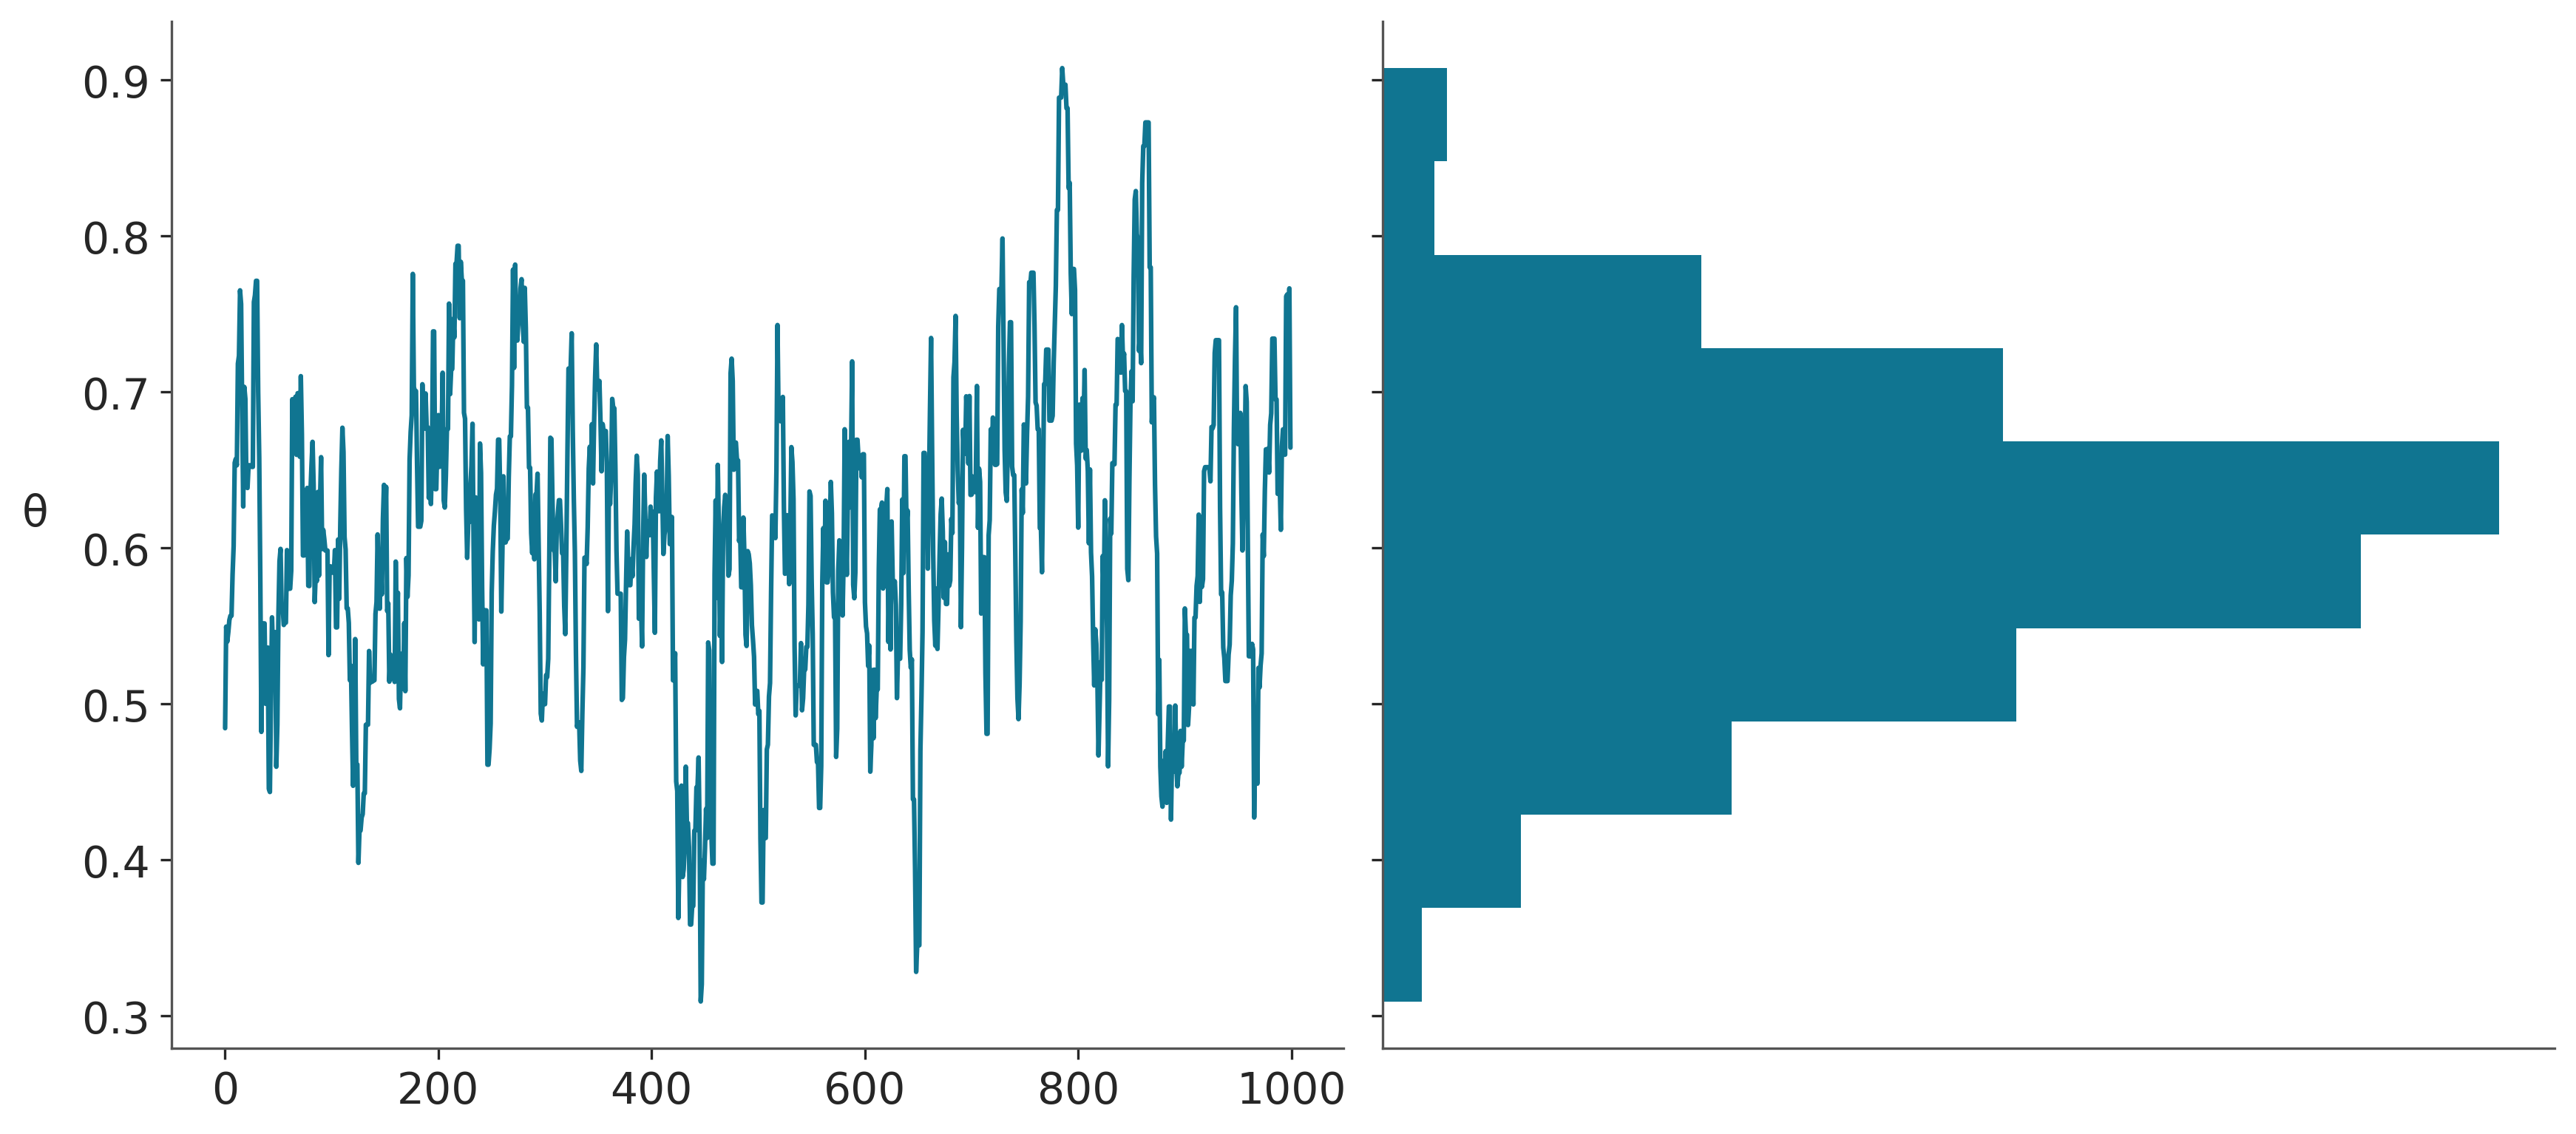

In [6]:
_, axes = plt.subplots(1,2, sharey=True)
axes[0].plot(trace['θ'])
axes[0].set_ylabel('θ', rotation=0, labelpad=15)
axes[1].hist(trace['θ'], orientation="horizontal", density=True)
axes[1].set_xticks([]);

[Acá](https://chi-feng.github.io/mcmc-demo/app.html?algorithm=RandomWalkMH&target=banana) pueden ver una versión interactiva de un Metropolis-Hastings

### MH adaptativo

Las garantías teóricas de MH y otros MCMC son válidas cuando la cantidad de pasos tiende a infinito. Si tomáramos infinitas muestras, cualquier distribución de propuesta nos conduciría al mismo resultado. Tampoco importaría el punto inicial. 

Sin embargo, no podemos tomar infinitas muestras y por lo tanto la eficiencia puede cambiar drásticamente de acuerdo a la distribución de propuesta que utilicemos y en menor medida al punto inicial. Además, la eficiencia de una distribución de propuesta dada dependerá de la geometría de la distribución a posteriori. Por ejemplo, si la distribución a posteriori es muy alargada en una dirección y muy angosta en otra, una distribución de propuesta que isotrópica será ineficiente. Es decir no existe una única distribución de propuesta que sea eficiente para todos los problemas.

Varios estudios teóricos muestran que bajos ciertas condiciones la tasa de aceptación óptima para MH es de 0.4 para distribuciones a posterirori unidimensionales y $\approx 0.234$ en el límite de dimensión infinita. En la práctica "infinito suele ser  $\lessapprox 10$". Estos resultados teóricos proporcionan una guía para diseñar métodos adatativos. Es decir podemos agregar al algortimo una primer fase the ajuste (tuning) donde se modifica algún aspecto de la distribución de propuesta de forma tal de lograr tasas de aceptación entre 0.23 y 0.4.

Existen muchos esquemas de ajuste uno común es usar como distribución de propuesta una gaussiana multivariada y ajustar la varianza de forma adaptativa. Muchas veces la matriz de covarianza usada es diagonal y se ajusta por separado cada componente. Estos esquemas adaptativos permiten que MH sea aplicado a una gran cantidad de problemas sin necesidad de realizar modificaciones al método.

Al usar métodos adaptativos hay que tomar alguno recaudos. Principalmente es importante destacar que las muestras generadas durante el ajuste no son muestras válidas. Esencialmente al cambiar lo hiper-parámetros del método, perdemos las garantías teóricas que aseguran que un MCMC sea valido. Es por ello que en la práctica se suele descartar las muestras generadas durante el ajuste. Vale aclarar que es posible diseñar esquemas de ajuste que no requieran descartar muestras, pero estos son más complejos y no son tan comunes.

Es posible tener que un algoritmo MCMC sea eficiente sin fase de ajuste, pero oso implica mucha suerte o que alguien se tomó el trabajo de ajusar el algoritmo a un caso particular.

En resumen, la fase de ajuste permite que el método MCMC se adapte a la geometría de la distribución a posteriori y por lo tanto permite generalizar estar métodos a una amplia variedad de problemas. Es por ello que los métodos MCMC a veces reciben el nombre de "motores de inferencia universal". El nombre es bastante rimbomante pero refleja el hecho, de que al menos en teoría, es posible escribir un modelo Bayesiano arbitrario y resolverlo. Esta separación entre modelo e inferencia es un aspecto central de la programación probabilista, ya que saca el foco del proceso de inferencia en si y pone todo el peso en el modelado. En la realidad esto es una verdad a medias, o si se quiere una promesa. En la práctica los métodos de MCMC son muy útiles hasta que dejan de serlo. Por ello es que necesitamos de métodos de diagnóstico del muestreo. 

## Diagnóstico del muestreo


Un método de diagnóstico, evalua alguna propiedad esperada de una muestra y nos indica sobre posibles desviaciones entre lo observado y lo predicho por la teoría. Si el diagnóstico encuentra un problema, en general es que hay un problema. Pero si el diagnóstico no encuentra un problema, no quiere decir, estrictamente, que este no exista. Además, como veremos no existe un criterio claro de demarcación. Es el problema del pelado. Se estima que un humano tienen alrededor de 150000 cabellos en su cabeza. Alguien con 0 pelos es claramente un pelado. Pero es dificil establecer un número único y no arbitrario que divida pelados de no pelados.


### Trace plots

Este es un gráfico muy común. Para cada parámetro graficamos su valor (eje-y) en cada iteración (eje-x). Lo esperable es no ver ningún patrón, solo ruido como en primer panel de la siguiente figura (marco turquesa). 

<center><img src=diapo/img/trace_single_good_bad.png width=800></center>

En cambio los otros tres paneles (marco magenta) muestran problemas. De izquierda a derecha y arriba a abajo:

* El segundo panel muestra que el muestreo es "pegajoso", le toma muchos pasos a la cadena moverse de valores altos a valores bajos, es difícil predecir que sucedería si seguimos corriendo, la cadena se movería hacia arriba nuevamente, se estabilizaría en valos bajos, continuaría bajando aún más?

* El tercer panel muestra una cadena menos "pegajosa", pero también daría la impresión que aún no ha terminado de estabilizarse

* El último panel, en cambio, muestra que hay una región donde el sampler se mueve bien, pero cada tanto "salta" a estados donde se queda atascado. Quizá esto se deba a una distribución a posteriori multimodal o dificultades en el sampler para explorar regiones con distinta curvatura. 

En general combine correr más de una cadena de MCMC empezando de puntos distintos. Lo esperable es que no podamos distinguir diferencias entre cadenas. Un traceplot con 4 cadenas superpuestas se ve así lo cual es un poco dificil de interpretar.


<center><img src=diapo/img/trace_multiple_good.png width=800/></center>


ArviZ permite graficar trace-plots usando la función `az.plot_trace()`. Por defecto obtenemos el trace a la derecha y un KDE (para variables continuas) y un histograma (para discretas) a la izquierda

<center><img src=diapo/img/trace_multiple_good_arviz.png width=900 /></center>

El KDE o histograma, también nos puedo ayudar a interpretar si hay problemas. Ya que esperamos que las distribuciones sean similares, más allá de un poco de ruido producto del número finito de muestras.


### Rank plots 

Los trace plots son muy comunes, pero existe una alternativa más moderna llamada rank plots. La idea básica es la siguiente. Para un parámetro tomamos todas las cadenas y ordenamos los valores de menor a mayor y les asignamos un rango es decir al valor más bajo le ponemos 0, al que sigue 1 y así hasta llegar a un número que será igual a la cantidad de muestras totales (cantidad de cadenas multiplicado por la cantidad de muestras por cadena). Luego reagrupamos los rankings según las cadenas que les dieron origen y para cada cadena hacemos un histograma. Si las cadenas fuesen indistinguibles esperaríamos que los histogramas sean uniformes. Ya que no hay razón para que una cadena tenga más rankings bajos (o medios o altos) que el resto.

La siguiente figura muestra 4 ejemplos, donde solo uno (marco cyan) no muestra problemas


<center><img src=diapo/img/rankbar_single_good_bad.png width=800></center>

En ArviZ los rank plots se pueden obtener con la función `az.plot_rank` o pasando un argumento a plot_trace `az.plot_trace(⋅, kind="rank_bars")`

### $\hat R$  (R sombrero)

Los gráficos suelen ser útiles para descubrir patrones, pero a veces queremos números, por ejemplo al evaluar rápidamente una lista de cientos, o miles, de parámetros. $\hat R$ es la respuesta a la pregunta ¿Lograron las cadenas *mezclarse* adecuadamente? 

En la literatura podrán encontrar que hay varias versiones de este diagnóstico, en texto viejos puede aparecer como Gelman-Rubin, por los nombres de los autores de la primer versión de este diagnóstico. Pero hoy en día contamos con versiones más modernas y más robustas y generales de las versiones anteriores. La versión implementada en ArviZ es la última versión de este diagnóstico y su cálculo tiene varios pasos. Pero la idea central es que compara la varianza *entre* cadenas con la varianza *dentro* de cada cadena. Si las cadenas provienen de la misma distribución entonces $\hat R = 1$. En la práctica se suele considerar que $\hat R \lessapprox 1.01$ son seguros. Pero acá retomamos el problema del pelado. El valor de corte es arbitrario, tiene cierto sustento empírico pero es arbitrario. Por ejemplo en la primer fase de modelado valores más altos como $\hat R \approx 1.1$ pueden estár bien. Además el valor de $\hat R \lessapprox 1.01$ es razonable cuando tenemos unos pocos parámetros pero es esperable que si tenemos muchos paramétros varios de ellos tengan valores de $\hat R$ mayores a 1.01. Un caso particular que veremos más adelante es el de BART, un método no paramétrico de regresión. Es conocido que BART suele generar valores de $\hat R$ relativamente alto y aún ser útil. 


La siguiente animación muestra, en el panel superior, 4 cadenas que progresivamente se van haciendo más similares. En el panel inferior tenemos 2 Gaussianas centradas en 0, una de ellas con las varianza intra cadena o y la otra entre cadenas.

<center><img src="diapo/img/r_hat.gif" width=900></center>



Usando ArviZ podemos obtener $\hat R$ usando `az.rhat(⋅)`, `az.summary(⋅)` y `az.plot_forest(⋅, r_hat=True)`

### Gráfico de autocorrelación

Idealmente, nos gustaría poder trabajar con muestras independientes e idénticamente distribuidas (iid). Por construcción, las muestras MCMC están correlacionadas, ya que la probabilidad de aceptar el paso $i$ depende del paso $i-1$. En la práctica, queremos muestras con baja autocorrelación. 

En ArviZ obtenemos este gráfico con la función `az.plot_autocorr()`

In [1]:
cadenas_defectuosas = {"cadenas_defectuosas": np.linspace(0, 1, 1000).reshape(2, -1)}
az.plot_autocorr(cadenas_defectuosas);

NameError: name 'np' is not defined

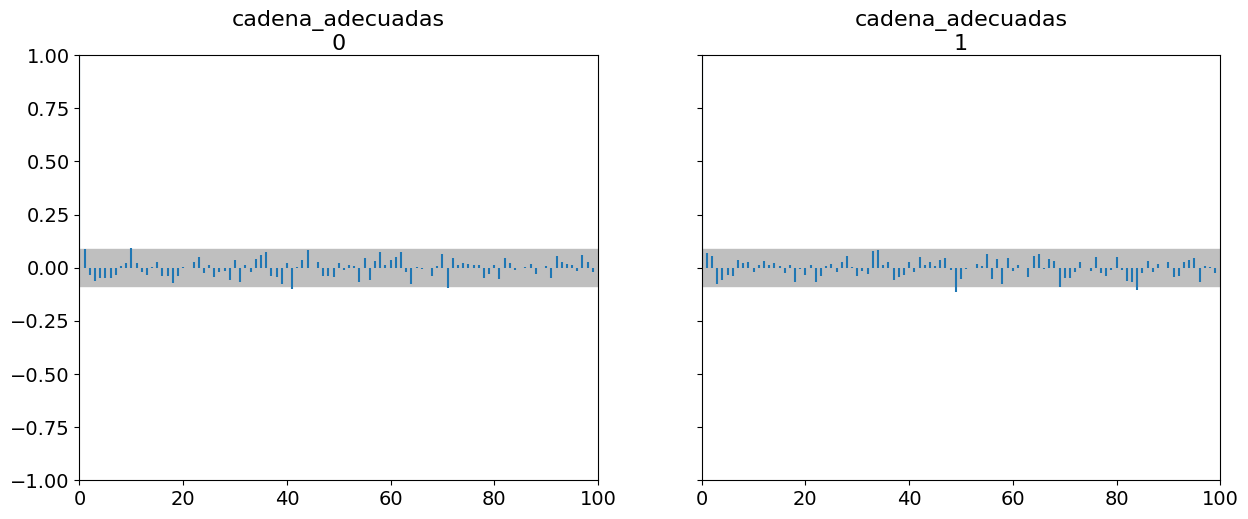

In [30]:
cadenas_adecuadas = {"cadena_adecuadas": pz.Uniform(0, 1).rvs(size=(2, 500))}
az.plot_autocorr(cadenas_adecuadas);

### Tamaño de muestra efectivo (ESS)

Como las muestras de un MCMC están correlacionadas la cantidad de información "útil" es menor que una muestra del mismo tamaño pero iid. 

La siguiente figura muestra la distribución correcta como una linea punteada y un histograma de muestras que sucesivamente van aumento. Podemos ver que en el panel de arriba, donde la muestra no están correlacionadas, obtenemos una mejor representación de la distribución real con un menor número de muestras que en el panel inferior donde las muestras si lo están. 

<br>
<br>
<center><img src="diapo/img/ess.gif" width=600></center>


Podemos estimar el **tamaño de muestra efectivo** (ESS), es decir, el tamaño de una muestra con la cantidad equivalente de información pero sin autocorrelación. Esto es útil para determinar si el tamaño de muestra que tenemos es lo suficientemente grande. Se recomienda que el ESS sea superior a 100 por cadena. Es decir para para 4 cadenas queremos un mínimo de 400.

Con ArviZ podemos obtenerlo `az.ess(⋅)`, `az.summary(⋅)` y `az.plot_forest(⋅, ess=True)`

In [2]:
pd.concat((az.ess(cadenas_defectuosas).to_pandas(),
           az.ess(cadenas_adecuadas).to_pandas()))

NameError: name 'pd' is not defined

Vemos que `az.summary(⋅)` devuelve dos valores de ESS, `ess_bulk` y `ess_tail`. Esto se debe a que, distintas regiones del espacio de los parámetros pueden tener distinto valor de ESS, ya que no todas las regiones son muestreadas con la misma eficiencia. Intuitivamente uno puede pensar que al muestrear una distribución como una Gaussiana es más fácil obtener mejor calidad de muestra alrededor de la media que de las colas, simplemente por que tenemos más muestras de esa región.

In [ ]:
pd.concat([az.summary(cadenas_adecuadas, kind="diagnostics"),
           az.summary(cadenas_defectuosas, kind="diagnostics")])

Si las muestras de MCMC las vamos a usar para calcular valores centrales como medias o medianas entonces tenemos que asegurarnos que el `ess_bulk` sea lo suficientemente algo, en cambio, si queremos calcular intervalos como un HDI 95% hay que asegurarse que `ess_tail` sea adecuado.

ArviZ ofrece varias funciones vinculadas al ESS. Por ejemplo si queremos evaluar el desempeño del sampler para varias regiones al mismo tiempo podemos usar `az.plot_ess`.

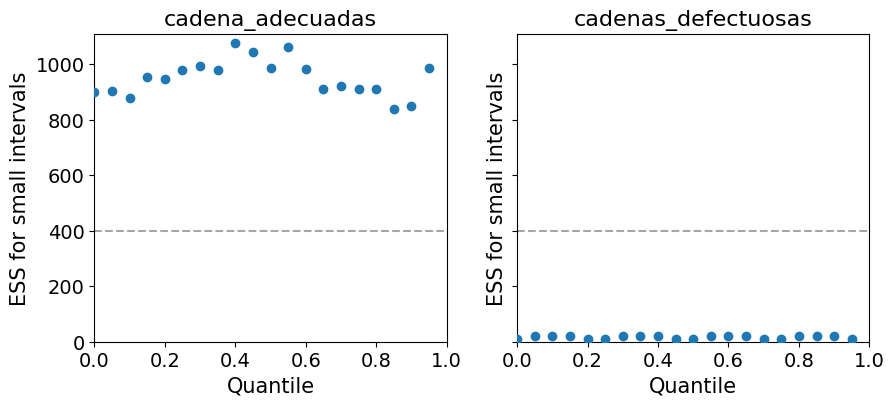

In [31]:
_, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)
az.plot_ess(cadenas_adecuadas, ax=axes[0])
az.plot_ess(cadenas_defectuosas, ax=axes[1]);

Una forma simple de aumentar el ESS es aumentar la cantidad de muestras, pero podría darse el caso que el ESS crezca muy lento con el número de muestras, por lo que aún si aumentáramos 10 veces la cantidad de muestras estaríamos por debajo de lo requerido. Una forma de estimar "cuanto nos falta" es usar `az.plot_ess(⋅, kind="evolution")`. Este gráfico nos muestra como fue cambiando el ESS con cada muestra, lo que nos permite hacer proyecciones. En el siguiente ejemplo vemos que para `cadenas_adecuadas` el ESS crece linealmente con el número de muestras mientras que para `cadenas_defectuosas` no crece para nada. Este último caso no hay esperanzas de mejorar el ESS simplemente aumentando la cantidad de muestras.

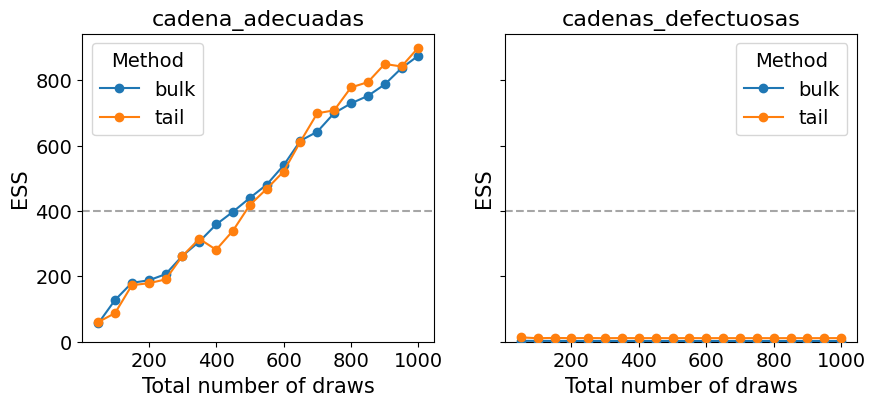

In [32]:
_, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)
az.plot_ess(cadenas_adecuadas, kind="evolution", ax=axes[0])
az.plot_ess(cadenas_defectuosas,  kind="evolution", ax=axes[1]);

### Error estándar del Monte Carlo (MCSE)

Una ventaja del ESS es que no tiene escala, da igual si un parámetro varía entre 0.1 y 0.2 y otro entre -2000 y 5000, un ESS de 400 tiene el mismo significado en ambos casos. En modelos con muchos parámetros rápidamente podemos indentificar cuales parámetros son más problemáticos. Sin embargo, a la hora de reportar resultados no es muy informativo saber si el ESS fue de 1372 o 1501. En cambio nos gustaría saber el orden del error que estamos cometiendo al aproximar la distribución a posteriori. Esa información la da el **error estándar del Monte Carlo** (MCSE). Al igual que el ESS, el MCSE tiene en cuenta la autocorrelación de las muestras. Este error debe estar por debajo de la precisión deseada en nuestros resultados. Es decir si para un parámetro el MCSE es 0.1, no tiene sentido reportar que la media de ese parámetro es 3.15. Ya que tranquilamente el valor correcto podría estar entre 3.4 y 2.8.

Una de las cantidades devueltas por `az.summary(⋅)` es mc_error.

### Montecarlo Hamiltoniano (HMC)

Supongamos que queremos simular el movimiento de una partícula sobre una superficie. Si queremos que nuestra simulación sea fidedigna necesitamos describirla usando las leyes de la física. Una forma de describir el movimiento de la partícula es utilizando lo que se conoce como mecánica Hamiltoniana. Sin entrar en detalles diremos que un Hamiltonianio es una descripción de la energía total de un sistema físico. Si asumimos que no hay fricción ni ninguna otra forma de "disipar" energía podemos describir el compartamiento de partícula sobre una superficie con solo 2 componentes. La energía cinética y la potencial. 

La energía cinética es la energía asociada al movimiento de la partícula y la potencial es la energía asociada a la posición de la partícula.  Supongamos que nuestra superficie tiene una forma de U. Y nuestra partícula está en la parte más baja. Esa partícula tendrá energía potencial 0 y si está quieta energía cinética 0. Nuestra simulación será terriblemente aburrida, ya que la partícula permanecerá en esa posición para siempre. Para ponerle algo de diversión podemos empujar la partícula, es decir le impartimos momentum, la partícula se moverá hacia arriba perdiendo cada vez más energía cinética (cada vez se moverá más lento) y ganando potencial, hasta que llegue a un punto en que se detenga, en ese punto toda la energía cinética se habrá convertido en potencial y la partícula comenzara a caer y la energía potencial se convertirá en cinética. Como no hay fricción la energía total del sistema se mantiene constante. Y todo los cambios en la energía cinética son compensados por cambios en la energía potencial.

Para un sistema como el que acabamos de describir la energía total será:

$$
\underbrace{H(\overbrace{\mathbf{q}}^{\text{posición}}, \overbrace{\mathbf{p}}^{\text{momemtum}})}_{\text{Hamiltoniano}}  = \underbrace{K(\mathbf{p}, \mathbf{q})}_{\text{Energía cinética}} + \underbrace{V(\mathbf{q})}_{\text{Energía potencial}}
$$

Desde un punto de vista matemático da igual si la superficie es una U, una montaña rusa, un satélite en órbita o incluso una distribución a posteriori. En todos estos casos podemos describir el movimiento de la partícula usando un Hamiltoniano.

La siguiente figura muestra un ejemplo de un distribución a posteriori 2D y multiples trayectorias de una partícula. En la figura se puede ver que iniciamos una simulación, la detenemos, marcamos un punto y empezamos desde ese punto empujando de vuelta la particula con una fuerza y direcciones arbitrarias.

<center><img src="diapo/img/Hamiltonian_Monte_Carlo.gif" width=400></center>

En el caso de la distribución a posteriori la posición de la particula son los valores de los parámetros. La energía potencial vendrá dada por la densidad de probabilidad a posteriori, estrictamente por el menos logaritmo de esa densidad. Y el momentum es una variable auxiliar. Es decir una variable completamente inventada, pero útil por que nos permite calcular el hamiltoniano. 

$$
H(\mathbf{q}, \mathbf{p}) = \overbrace{-\log p(\mathbf{p} \mid \mathbf{q})}^{K(\mathbf{p}, \mathbf{q})} \overbrace{- \log p(\mathbf{q})}^{ + V(\mathbf{q})}
$$

Fijensé que en este punto no estamos haciendo ninguna analogía, estrictamente un Hamiltonian MonteCarlo es un método que simula el movimiento de una partícula en un espacio de parámetros.

A grandes rasgos un HMC tiene dos pasos que se repiten hasta obtener la cantidad de muestras necesarias:

1. Generar un nuevo punto a partir del hamiltoniano
2. Aceptar o rechazar ese nuevo punto según el criterio de metropolis.

Para generar mejor intuición recomiendo jugar con ese [demo](https://chi-feng.github.io/mcmc-demo/app.html?algorithm=NaiveNUTS&target=banana)


### Propuestas aleatorias vs hamiltonianos

Por qué es buena idea usar el Hamiltoniano? Porque estamos explorando la distribución a posteriori siguiendo una representación fidedigna de la misma. OK, esto es cierto pero no genera demasiada intuición. Veamos un par de enfoques alternativos. 

En un MH la propuesta es aleatoria, es como querer encontrar algo en una habitación desconocida a oscuras, hay que ir a tientas. Si la habitación es pequeña y simple (cuadrada, con pocos muebles, escaleras etc) hacerlo a ciegas no será tarea demasiado compleja. Sin embargo con el Hamiltoniano es como tener una linterna, ahora podemos ver, al menos localmente, que hay en la habitación, por lo que recorrerla será más eficiente. 

Vamos con otra explicación, para resolver un hamiltoniano necesitamos calcular derivadas, las derivadas nos dan información sobre la curvatura de una función, por ejemplo el cálculo de la primer derivada en un punto nos dice hacia donde (de)crece una función. Si siguiéramos la derivada hacia donde crece la función, eventualmente llegaríamos a un máximo (asumiendo que este existe). Esto se llama maximizar una función y de hecho muchos métodos de minimización de funciones como los encontrados en [SciPy.optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html) utilizan derivadas. Al agregar el *momemtum* podemos hacer algo más interesante, no solo podemos encontrar máximos, también podemos escapar de ellos. Esto nos permite obtener puntos de toda la distribución a posteriori de forma eficiente. Esto es importante en estadística Bayesiana, ya que no solo queremos el máximo, si no una descripción de toda la distribución a posteriori.


<center><img src="diapo/img/hmc_landscape.gif" width=700></center>


### HMC dinámico y adaptativo

Un HMC tiene varios hipeparámetros, por ejemplo para simular una trayectoria tenemos que hacerlo de a pasos discretos, mientras más pequeños los pasos más fidedigna la simulación, pero también más costosa. Otro hiperparámetro es la longitud de cada simulación si esta es muy corta demoraremos mucho tiempo en explorar la distribución a posteriori, pero si está es muy larga corremos el riesgo de retornar al punto de partida, o sus inmediaciones, es decir habremos gastado un montón de recursos para terminar en el mismo lugar.


En la siguiente figura se muestran tres ejemplos. A la izquierda el paso es muy corto, por lo que la exploración no es eficiente, en el centro tenemos un mejor paso pero simulamos durante tanto tiempo que terminamos regresando al punto de partida. Finalmente y a la derecha tanto el paso como el tiempo de simulación son adecuados. Decimos que es adecuado, ya que logramos genear un nuevo punto que simultaneamente está alejado en el espacio de los parámetros, pero con alta probabilidad de aceptación. De hecho en este ejemplo la probabilidad de aceptación es 1, ya que el valor de la pdf es el mismo para el punto de partida y para el punto final.

<center><img src="img/hmc_1D.gif" width=900></center>

Este es otro ejemplo, en cada caso se muestra una densidad de probabilidad que va de más probable (amarillo) a menos probable (violeta), las flechas naranjas indican la trayectoria calculada de a pasos. En en el primer caso vemos una trayectoria elíptica tan larga que vuelve al punto de partida. En el segundo ejemplo vemos que el paso no es adecuado, esto produce una simulación inestable que se manifiesta en **divergencias** de la trayectoria correcta.  En este último caso, y como en el ejemplo anterior, vemos que tanto el paso como el tiempo de simulación son adecuamos y la propuesta genera un punto alejado en el espacio de los parámetros, pero con alta probabilidad de aceptación (1 en este caso).


<center><img src="diapo/img/HMC_trayectoria.png" width=900></center>

Las divergencias ocurren cuando hay cambios de "curvatura" demasiado bruscos. Es decir cuando la partícula pasa de zonas de baja densidad de probabilidad a zonas de alta densidad o viceversa. En estos casos el método de integración numérica que se utiliza para resolver el hamiltoniano no es suficientemente preciso. PyMC registra cuando las divergencias ocurren y como veremos más adelante, es posible utilizar las divergencias para diagnosticar problemas con el método de muestreo.

Al igual que en un MH adaptativo, en un HMC también necesitamos ajustar la matriz de covarianza, usualmente llamada Matriz de Masa (mass matrix). En HMC esta matriz es la que determina el momemtum.


Cuando los hiper-parámetros de un HMC son adecuados, el muestreo es muy eficiente. De hecho es mucho más eficiente que un MH. Los valores de los hiper-parámetros dependen esencialmente de la geometría de la distribución a posteriori, por lo que no existe un solo conjunto de hiper-parámetros mejor que los demás. Es por ello que en la práctica estos se calculan de forma adaptativa corriendo una cantidad de pasos de HMC los cuales se utilizan para ajustar eso hiper-parámetros automáticamente y luego se descartan. 

NUTS (No U-Turn sampler), el sampler por defecto en PyMC es un HMC dinámico y adaptativo. El nombre proviene de una rutina del método que evita que las trayectorias den vueltas en U. Este método detecta en cada paso de si estamos retornando el punto de partida, de ser así detiene el paso, evalúa si aceptar o no y comienza un nuevo paso. Al evitar trayectoria que vuelven al punto de partida, NUTS es capaz de explorar la distribución a posteriori de forma más eficiente. 

### Diagnóstico de algoritmos basados en gradiente

Debido a su funcionamiento interno, algoritmos como NUTS  ofrecen algunas pruebas específicas que no están disponibles para otros métodos. Generalmente estas pruebas son muy sensibles

Para ejemplificar esto vamos a cargar dos InferenceData de modelos pre-calculados. Los detalles de como se generaron estos idatas no son relevantes por el momento. Solo diremos que son dos modelos que son matemáticamente equivalente pero parametrizados de formas distintas. En este caso la parametrización afecta la eficiencia del sampler. El modelo `centrado` es muestreado de forma más eficiente que el modelo `no centrado`.

In [33]:
idata_cm = az.load_arviz_data("centered_eight")
idata_ncm = az.load_arviz_data("non_centered_eight")

### Divergencias

Una ventaja de NUTS es que *falla con el estilo*. Esto sucede por ejemplo al intentar pasar de regiones de baja curvatura a regiones de alta curvatura. En estos casos las trayectorias numéricas pueden divergir. En esencia esto sucede porque en esos casos no existe un único conjunto de hiper-parámetros que permita el muestreo eficiente de ambas regiones. Por lo que una de la regiones es muestreada adecuandamente y cuando el sampler se mueve hacia la otra región falla. Las trayectorias numéricas divergentes son identificadores extremadamente sensibles de *vecindarios patológicos*.

El siguiente ejemplo muestra dos cosas el modelo `no centrado` muestra varias divergencias (círculos turquesas) agrupados en una región. En el modelo `centrado`, que no tiene divergencias, se puede ver que alrededor de esa misma región hay muestras para valores más pequeños de `tau`. Es decir el modelo `no centrado` falla en muestrear una región, pero al menos avisa que está teniendo problemas en muestrear esa región!

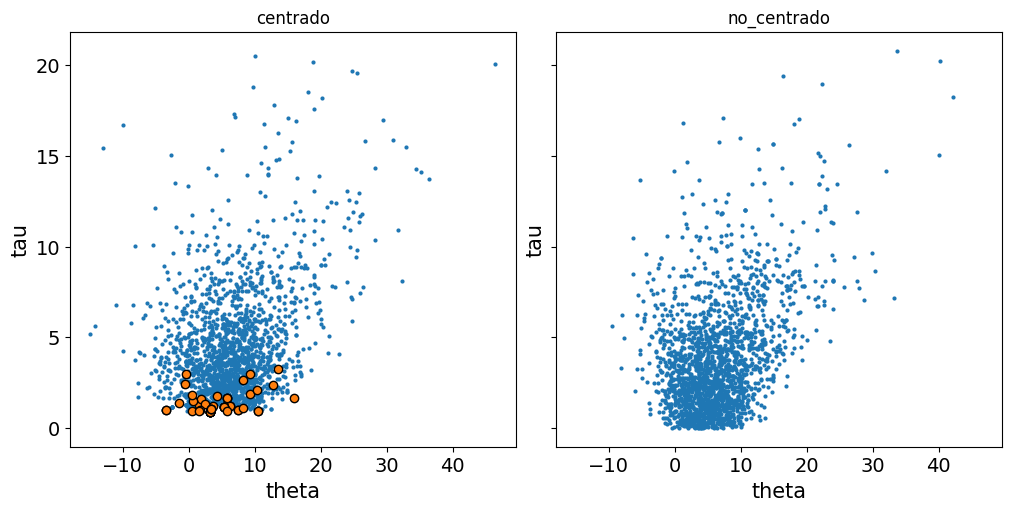

In [35]:
_, axes = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 5), constrained_layout=True)


for ax, idata, nombre in zip(axes.ravel(), (idata_cm, idata_ncm), ("centrado", "no_centrado")):
    az.plot_pair(idata, var_names=['theta', 'tau'], coords={'school':"Choate"}, kind='scatter',
                 divergences=True, divergences_kwargs={'color':'C1'},
                 ax=ax)
    ax.set_title(nombre)

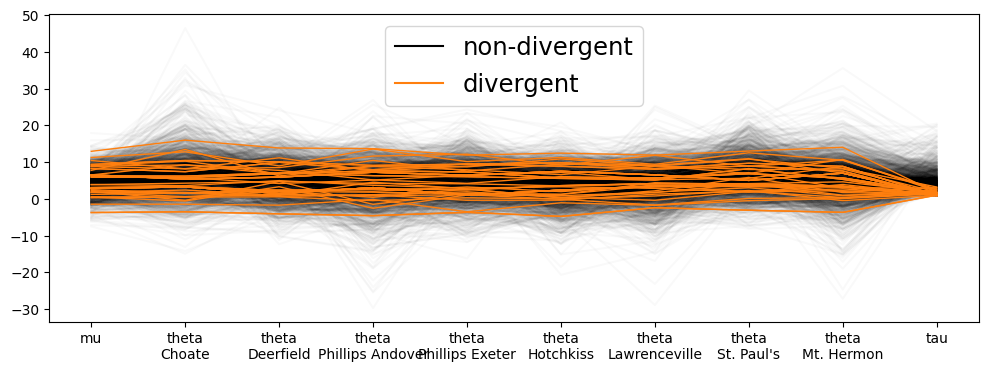

In [36]:
az.plot_parallel(idata_cm, figsize=(12, 4));

## Qué hacer cuando los diagnósticos no dan bien?

<br>

* <font color = gray> Más muestras o más pasos de tuning. Esto solo suele ser útil cuando los problemas son menores</font>

* <font color = gray> Burn-in. Los métodos MCMC, pueden demorar un tiempo en converger. En estos casos una solución simple es eliminar la primer porción de muestras, lo que se llama burnin. Software moderno como PyMC utiliza una cantidad de muestras para ajustar los hiper-parámetros de los métodos de muestreo. Por defecto esas muestras son eliminadas, por lo que en general no es necesario hacer burn-in manualmente. Pero lo mencionamos, ya que es una práctica que suele mencionarse en la literatura.</font>

* <font color = gray> Cambiar el método de muestreo! </font>


* Reparametrizar el modelo

* <font color = orange> Mejorar las distribuciones _a priori_ </font>
    * El _teorema popular_ de la estadística computacional: Cuando tienes problemas computacionales, a menudo hay un problema con tu modelo. La recomendación NO es cambiar la distribución _a priori_ para mejorar la calidad del muestreo. La recomendación es que si el muestreo es malo, quizá el modelo también lo sea. En ese caso, podemos pensar en mejorar el modelo, una forma de mejorarlo es usar conocimiento previo para mejorar las distribuciones _a priori_.

* Algunos modelos pueden expresarse en más de una forma, todas matemáticamente equivalentes. En esos casos, algunas parametrizaciones pueden ser más eficientes que otras. Por ejemplo, como veremos más adelante con modelos lineales jerárquicos.

* En el caso de las divergencias, estas suelen eliminarse aumentando la tasa de aceptación (`pm.sample(..., target_accept=x)` x>0.8)

* Leer los mensajes de advertencia y sugerencias de PyMC!   ;-)

## Una hoja de ruta para el Bayesian workflow

A continuación se describen una serie de consejos y recomendaciones a modo de referencia rápida, sobre como encarar un análisis de datos y modelado. Las recomendaciones están orientadas a estadística Bayesiana en particular, pero pueden ser útiles al utilizar otro tipo de herramientas y modelos. 

Las recomendaciones están escritas de forma lineal, pero en la práctica, es posible que debas retroceder uno o más pasos y, a veces, omitir pasos. Piensa en estas notas, no como una partitura de una pieza clásica que un violinista tiene que seguir exactamente, sino como la partitura que sigue un bajista de Jazz, eres libre de improvisar, reorganizar algunas partes y omitir otras, e incluso puedes agregar tus propias notas!


### Resume el problema

Resuma los puntos clave de su problema y lo que le gustaría aprender de los datos. Piensa también en los demás, en lo que a tu jefe, cliente o colega le gustaría saber o aprender. No es necesario que esto sea muy completo; puedes revisar los objetivos más adelante, pero pueden ayudarte a organizar tus esfuerzos de modelado y evitar desviaciones excesivas.

Comuníquese con las partes interesadas cuando surjan dudas. Una respuesta de la persona adecuada, puede ahorrarnos horas de trabajo.

A veces no tendrás una idea clara de como enfocar un análisis; tu única expectativa podría ser obtener "algo útil" de un conjunto de datos, y eso está bien. Pero otras veces puede que incluso sepas qué tipo de modelo quieres, tal vez tu jefe te pidió explícitamente que ejecutaras tal o cual análisis. Si ya sabe qué tipo de modelo o herramienta es necesaria, pero no está muy familiarizado con el enfoque, busque qué métodos, métricas o visualizaciones son comunes para ese problema/datos y pida consejo a otros. Esto es más importante cuanto menos familiarizado esté con ese tipo de problema/datos. Si está familiarizado, es posible que ya sepa qué métodos, visualizaciones y resúmenes desea utilizar u obtener. 

Escriba todos estos elementos preliminares como una lista de puntos a tener en cuenta o una hoja de ruta a seguir, en problemas complejos es fácil perder el foco. Esta lista puede ser revisada y actualizada de ser necesario, pero es importante establecer expectativas preliminares de lo que es deseable e ir actualizándolas según lo que sea posible. Quizá los datos no sirvan para contestar lo que nos interesa, o quizá necesitamos información extra o incluso puede que hayamos encontrado algo aún mas importante que lo que queríamos originalmente.

### Familiarízate con los datos

Siempre es una buena idea realizar un análisis exploratorio de los datos. Modelar ciegamente tus datos te lleva a todo tipo de problemas. Tomarse el tiempo de mirar los datos es rara vez una pérdida de tiempo y al contrario suele ahorrarnos tiempo y proporcionar ideas útiles. A veces un buen resumen de los datos puede ser suficiente para nuestro propósito y hacer innecesarias otras aproximaciones más complejas como modelos estadísticos o de otros tipos.

La exploración de los datos debe conducir al entendimiento de los mismos. La forma exacta de lograr esto puede variar mucho de un conjunto de datos a otro y de un análisis a otro. Pero hay comprobaciones que suelen ser útiles, como comprobar si hay valores faltantes o errores en los datos. Es importantes considerar el contexto. Una valor de 200 es razonable si se refiere al peso en gramo de frutas, pero *problemático* si se refiere a registros de clima en el planeta Tierra. ¿Son correctos los tipos de datos? ¿Todos los valores que deberían ser números, son realmente números (generalmente enteros o flotantes) o son cadenas? ¿Qué variables son categóricas? ¿Cuáles son continuos? En esta etapa, es posible que deba realizar una limpieza de sus datos. Esto le ahorrará tiempo en el futuro. Y es posible que sea necesario comunicarse con quien generó o proveyó los datos, para asegurarse que estamos interpretando de forma correcta los datos y que cualquier procesamiento de los mismos es correcto.

Por lo general, también nos gustaría hacer algunos gráficos, histogramas, diagramas de caja, diagramas de dispersión, matrices de correlaciones, etc. Además de los gráficos, también calcule resúmenes numéricos, medias y medianas, para todos los datos, o agrupando los datos, etc.

Acá es importante llevar registro de lo que se va observando. Cualquier cosa que resulte llamativa, inesperada o que consideremos relevante para análisis posteriores. En esta etapa los gráficos y análisis no tienen que ser extremadamente prolijos. Después de todo es un análisis preliminar, pero mantener cierto orden es de utilidad. Un análisis más o menos ordenado puede ser suficiente para compartir en una discusión técnica con colegas o clientes. Incluso puede ser muy útil para nuestros yo futuro, nada tan frustrante como retomar un análisis luego de un par de meses y no entender que fue lo que nosotros mismos hicimos!


### Cuente una historia para los datos

A menudo resulta útil pensar en cómo se podrían haber generado los datos. Esto suele denominarse **proceso generador de datos** o mecanismo de generación de datos. No necesitamos descubrir el mecanismo verdadero, muchas veces sólo necesitamos pensar en mecanismos plausibles.

Haz dibujos y trata de ser muy esquemático, garabatos y figuras geométricas deberían ser suficientes a menos que seas un buen dibujante. Este paso puede ser complicado, así que usemos un ejemplo. Digamos que estás estudiando los niveles de agua de un lago, piensa en qué hace que el agua aumente; lluvia, ríos, etc, y lo que la hace disminuir; evaporación, animales bebiendo agua, producción de energía, etc. Intenta pensar cuáles de estos elementos pueden ser relevantes y cuáles podrían ser insignificantes. Utilice todo el contexto que tenga para su problema.

Intente mantenerlo simple pero no más simple. Por ejemplo, un mecanismo podría ser "El peso de los cerdos aumenta cuando se les dá mayor cantidad de maíz", ese es un buen mecanismo si todo lo que necesita predecir son sus ganancias por la venta de cerdos. Pero será un mecanismo demasiado simplista si se estudia la absorción intestinal a nivel celular.

Si se te ocurren historias alternativas y no sabes decidir cuál es mejor. ¡No te preocupes, enuméralas todos! ¡Quizás podamos usar los datos para decidir!


### Escribe un modelo

Intente traducir el proceso generador de datos a un modelo. Si te sientes cómodo con las matemáticas, úsalas. Si prefiere una representación visual como un modelo gráfico, úsela. Si te gusta el código, hazlo. Los modelos incompletos están bien como primer paso. Por ejemplo, si usa código, siéntase libre de usar pseudocódigo o agregar comentarios para señalar los elementos que faltan mientras piensa en el modelo. Puedes refinarlo más tarde.

Intente comenzar de manera simple, no use jerarquías, preferible empezar con priors unidimensionales e independientes, omita interacciones para modelos lineales, etc. Si por alguna razón el punto de partida es un modelo complejo, está bien, puede pensar en formas de simplificarlo.

A veces, es posible que puedas utilizar un modelo de libro de texto estándar o algo que hayas visto en una publicación de blog o en una charla. Es común que para ciertos problemas la gente tienda a utilizar ciertos modelos "predeterminados". Puede que sea un buen comienzo, o quizá todo lo que necesite. Mantenga las cosas simples, a menos que necesite algo más.

Este es un buen paso para pensar en tus antecedentes, no solo qué familia vas a utilizar, sino qué parámetros específicos. Si no tienes ni idea, utiliza un previo vago. Pero si tienes alguna información úsala. Intente codificar información muy general, como que este parámetro no puede ser negativo, o es probable que este parámetro sea más pequeño que esto o esté dentro de este rango. Busque la fruta madura, normalmente eso será suficiente. La excepción será cuando tengas suficiente información de buena calidad para definir un previo muy preciso, pero incluso entonces, eso es algo que puedes agregar más adelante.


### Implementar el modelo

Escriba el modelo en un lenguaje de programación probabilístico. Si usó código en el ejemplo anterior, la línea entre este paso y el anterior puede ser difusa, está bien. Intente mantener el modelo simple al principio; agregaremos más capas más adelante a medida que sigamos iterando el flujo de trabajo. Empezar de forma sencilla normalmente le ahorra tiempo a largo plazo. Los modelos simples son más fáciles de depurar y depurar un problema a la vez es generalmente menos frustrante que tener que solucionar varios problemas antes de que nuestro modelo se ejecute.

Una vez que tenga un modelo, verifique que el modelo se compile y/o ejecute sin errores. Al depurar un modelo, especialmente en una etapa inicial del análisis, es posible que desee trabajar con un conjunto de datos reducido, por ej un 50% o 10% si el conjunto de datos es demasiado grande, o tal vez comenzar con solo unas pocas covariables, y luego agrega el resto. Esto puede ayudar a acelerar el modelo, para que pueda cambiarlo e iterar más rápido. Esto tiene la desventaja de que es posible que se pierdan los datos necesarios para descubrir algún patrón relevante, pero podría estar bien al principio, cuando suele ser el momento en el que cometerá la mayoría de los errores o tendrá mayores dudas sobre lo que está haciendo. En las primeras etapas, también puede reducir la cantidad de pasos de ajuste y muestreo.


### Evaluar la distribución predictiva a priori

Generalmente es una buena idea generar datos a partir de la distribución predictiva a priori y compararlos con su conocimiento previo. ¿Está la mayor parte de la distribución simulada dentro de un rango razonable? ¿Existen valores extremos? Utilice valores de referencia como guía. Los valores de referencia son datos empíricos u observaciones históricas, normalmente serán valores mínimos, máximos o esperados. Evite comparar con los datos observados, ya que eso puede generar problemas si no es lo suficientemente cuidadoso.


### Calcular la distribución a posteriori

Hay muchas formas de calcular el a posteriori; en esta serie de recomendaciones asumimos el uso de métodos MCMC, ya que son los métodos más generales y más usados.


### Evaluar muestras

Cuando utilizamos métodos MCMC, debemos comprobar que las muestras sean lo suficientemente buenas. Para ello, necesitamos calcular diagnósticos como $\hat R$ (r-hat) y el tamaño de muestra efectivo (ESS). Y evalúe gráficos como traceplot y rank-plots. No es necesario que los diagnósticos sean tan buenos en las primeras etapas del flujo de trabajo. Al mismo tiempo, un diagnóstico muy malo podría ser una señal de un problema con nuestro(s) modelo(s).

### Validar el modelo

Hay muchas formas de validar su modelo, como una prueba predictiva a posteriori, valores p Bayesianos, análisis de residuos, recuperación de parámetros a partir de datos sintéticos. O una combinación de todo esto. A veces es posible que puedas utilizar un conjunto de extra de datos para evaluar el rendimiento predictivo de tu modelo. El objetivo principal aquí es encontrar si el modelo es lo suficientemente bueno para su propósito y qué limitaciones puede tener. Todos los modelos tendrán limitaciones, pero algunas limitaciones pueden ser irrelevantes en el contexto de su análisis, algunas pueden valer la pena eliminarlas mejorando los modelos y otras simplemente vale la pena saber que existen.

### Comparar modelos

Si logras conseguir más de un modelo (normalmente es una buena idea), es posible que tengas que definir cuál te gustaría conservar (suponiendo que sólo necesitas uno). Para comparar modelos se pueden utilizar validación cruzada (incluido LOO) y/o criterios de información. Pero también puedes utilizar los resultados del paso anterior (validación del modelo). A veces comparamos modelos para mantener un solo modelo, la comparación de modelos también puede ayudarnos a comprender mejor un modelo, sus fortalezas y limitaciones, y también puede ser una motivación para mejorar un modelo o probar uno nuevo. El promediado de modelos, es decir, la combinación de varios modelos en uno solo, suele ser una estrategia sencilla y eficaz para mejorar el rendimiento predictivo.

### Resumir resultados

Resuma los resultados de una manera que le ayude a alcanzar sus objetivos. ¿Logró responder las preguntas clave? ¿Es esto algo que convencerá a tu jefe o al departamento de marketing? Piense en formas efectivas de mostrar los resultados. Si su audiencia es muy técnica, haga un resumen técnico, pero si su audiencia solo se preocupa por maximizar ganancias, concéntrese en eso. Intenta utilizar resúmenes que sean fáciles de entender sin ocultar detalles valiosos, no querrás engañar a tu audiencia.


## Comentarios finales


En conclusión, el flujo de trabajo Bayesiano no es un conjunto rígido de instrucciones sino un enfoque de modelado dinámico y en evolución. Piense en ello como un marco conceptual que guía sus pensamientos y acciones en la búsqueda de mejores modelos y análisis.

Los métodos, herramientas y prácticas para el análisis Bayesiano mejorarán con el tiempo. A medida que avance la tecnología, es esperable una mayor automatización y mejorar en las herramientas de software y esta guía evolucionará en consecuencia.

Además, el flujo de trabajo Bayesiano subraya la importancia de valorar tanto el viaje como el destino. Fomenta una comprensión más profunda del problema y mejora las habilidades aplicables en diversos dominios. En última instancia, el flujo de trabajo Bayesiano representa un compromiso con el aprendizaje y el refinamiento continuos en el modelado y el análisis.

## Ejercicios

1. (Borrador, Está bien esto como ejercicio o lo demostramos en el texto?) Demuestre que la transformada integral de probabilidad es cierta.

1. (Borrador) Usando la transformada integral de probabilidad describa una método general para generar muestreas aleatorias de cualquier distribución a partir de una distribución uniforme.

1. (Borrador) deberíamos tener una serie de ejercicios donde calculen los valores-p marginales para distribuciónes sintéticas, por tomar una Gaussiana de base y comparar con 
* una gaussian más ancha, otra más angosta y otra desplazada y ver en cada caso como la distribución se desvía de la uniforme.